# Tu travailles dans une banque. Ton modèle prédit si un client risque de ne pas rembourser son crédit.
Tu disposes d’un jeu de données de clients passés.

In [1]:

import pandas as pd  # Pour la manipulation de données avec les DataFrames
import numpy as np  # Pour les calculs mathématiques et les opérations sur tableaux
import matplotlib.pyplot as plt  # Pour la création de graphiques simples
import seaborn as sns  # Pour des visualisations statistiques plus avancées
import scipy.stats as stat  # Pour les tests statistiques (distribution, tests de normalité, etc.)
# Pour la gestion des valeurs manquantes
from sklearn.impute import SimpleImputer
# Pour la division du jeu de données, la validation croisée et la recherche d’hyperparamètres
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, validation_curve, cross_val_score
# Pour appliquer différentes transformations selon le type de colonnes
from sklearn.compose import ColumnTransformer
# Pour la standardisation des variables numériques et le codage des variables catégorielles
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# Pour la réduction de dimensionnalité (ex. : ACP - Analyse en Composantes Principales)
from sklearn.decomposition import PCA
# Pour créer des pipelines de traitement avec gestion du déséquilibre des classes
from imblearn.pipeline import Pipeline
# Pour appliquer la technique de sur-échantillonnage (équilibrer les classes minoritaires)
from imblearn.over_sampling import SMOTE
# Pour appliquer la technique de sous-échantillonnage (réduire les classes majoritaires)
from imblearn.under_sampling import RandomUnderSampler
# Pour connaître la distribution des classes (utile avant/ après équilibrage)
from collections import Counter
# Pour gérer certaines erreurs comme les modèles non encore entraînés
from sklearn.exceptions import NotFittedError
# Importation de quelques modèles d’apprentissage supervisé
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Pour évaluer les performances des modèles
from sklearn.metrics import (
    confusion_matrix,       # Matrice de confusion
    roc_curve,              # Courbe ROC
    roc_auc_score,          # Aire sous la courbe ROC
    precision_recall_curve, # Courbe précision-rappel
    auc,                    # Aire sous la courbe (ROC ou PR)
    classification_report   # Rapport complet : précision, rappel, F1-score
)
# Pour sauvegarder ou charger un modèle
import joblib as jb
# Pour désactiver les avertissements liés à l'affectation dans des DataFrames
pd.options.mode.chained_assignment = None


In [2]:

# Définition manuelle des noms de colonnes (pour remplacer les noms d'origine)
col_name = [
    "age", "rev_annuel", "propriete", "duree_emploi",
    "intention", "categorie_pret", "montant", "interet", "statut",
    "pourcentage_rev", "defaut_historique", "duree_credit"
]
card = pd.read_csv("credit_risk_dataset.csv", delimiter=",")
# Renommage des colonnes
# On crée un dictionnaire associant les anciens noms de colonnes aux nouveaux noms définis
dict_col = dict(zip(card.columns.to_list(), col_name))
# On applique le renommage directement sur le DataFrame
card.rename(columns=dict_col, inplace=True)
# Séparation des colonnes numériques et catégorielles
# On récupère la liste des colonnes de type numérique (int ou float)
num = card.select_dtypes(include=[float, int]).columns.to_list()
# On récupère la liste des colonnes de type objet (chaîne de caractères => catégorielles)
cat = card.select_dtypes(include=["object"]).columns.to_list()
# On retire la variable "statut" des colonnes numériques car c'est la **variable cible** (catégorielle)
num.remove("statut")
#  Vérification des valeurs manquantes
print(card.isnull().sum())


age                     0
rev_annuel              0
propriete               0
duree_emploi          895
intention               0
categorie_pret          0
montant                 0
interet              3116
statut                  0
pourcentage_rev         0
defaut_historique       0
duree_credit            0
dtype: int64


In [3]:
card.head()

,age,rev_annuel,propriete,duree_emploi,intention,categorie_pret,montant,interet,statut,pourcentage_rev,defaut_historique,duree_credit
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
#  Imputation des valeurs manquantes dans la colonne "interet"
impiter = SimpleImputer(missing_values=np.nan, strategy="mean")
# Application de l’imputation uniquement sur la colonne "interet"
card.loc[:, "interet"] = impiter.fit_transform(card[["interet"]])
# Suppression des autres lignes avec des valeurs manquantes restantes
card = card.dropna(axis='index')
print(card.isnull().sum())


age                  0
rev_annuel           0
propriete            0
duree_emploi         0
intention            0
categorie_pret       0
montant              0
interet              0
statut               0
pourcentage_rev      0
defaut_historique    0
duree_credit         0
dtype: int64


**1 1.ANALYSE UNIVARIEE**

In [5]:
# Analyse de la dimensionnalité
print(" Nous disposons de ", card.shape[0], "Clients")
print("Nous avons ", card.shape[1], "éléments caractérisant chaque client")

 Nous disposons de  31686 Clients
Nous avons  12 éléments caractérisant chaque client


In [6]:
 print(card.info())

<class 'pandas.core.frame.DataFrame'>
Index: 31686 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                31686 non-null  int64  
 1   rev_annuel         31686 non-null  int64  
 2   propriete          31686 non-null  object 
 3   duree_emploi       31686 non-null  float64
 4   intention          31686 non-null  object 
 5   categorie_pret     31686 non-null  object 
 6   montant            31686 non-null  int64  
 7   interet            31686 non-null  float64
 8   statut             31686 non-null  int64  
 9   pourcentage_rev    31686 non-null  float64
 10  defaut_historique  31686 non-null  object 
 11  duree_credit       31686 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.1+ MB
None


In [7]:
# Statistique descriptivedes variablesquantitatives
num_descriptive= np.round(card.select_dtypes(include=["float64","int64"]).describe().T,2)
num_descriptive

,count,mean,std,min,25%,50%,75%,max
age,31686.0,27.75,6.36,20.00,23.00,26.00,30.00,144.00
rev_annuel,31686.0,66691.88,62427.29,4000.00,39397.00,56000.00,80000.00,6000000.00
duree_emploi,31686.0,4.79,4.14,0.00,2.00,4.00,7.00,123.00
montant,31686.0,9661.34,6336.23,500.00,5000.00,8000.00,12500.00,35000.00
interet,31686.0,11.04,3.07,5.42,8.49,11.01,13.16,23.22
statut,31686.0,0.22,0.41,0.00,0.00,0.00,0.00,1.00
pourcentage_rev,31686.0,0.17,0.11,0.00,0.09,0.15,0.23,0.83
duree_credit,31686.0,5.81,4.06,2.00,3.00,4.00,8.00,30.00


In [8]:
 # Statistique des variables qualitatives
object_descriptive = card.select_dtypes(include= ["object"]).describe().T
object_descriptive

,count,unique,top,freq
propriete,31686,4,RENT,16076
intention,31686,6,EDUCATION,6290
categorie_pret,31686,7,A,10371
defaut_historique,31686,2,N,26057


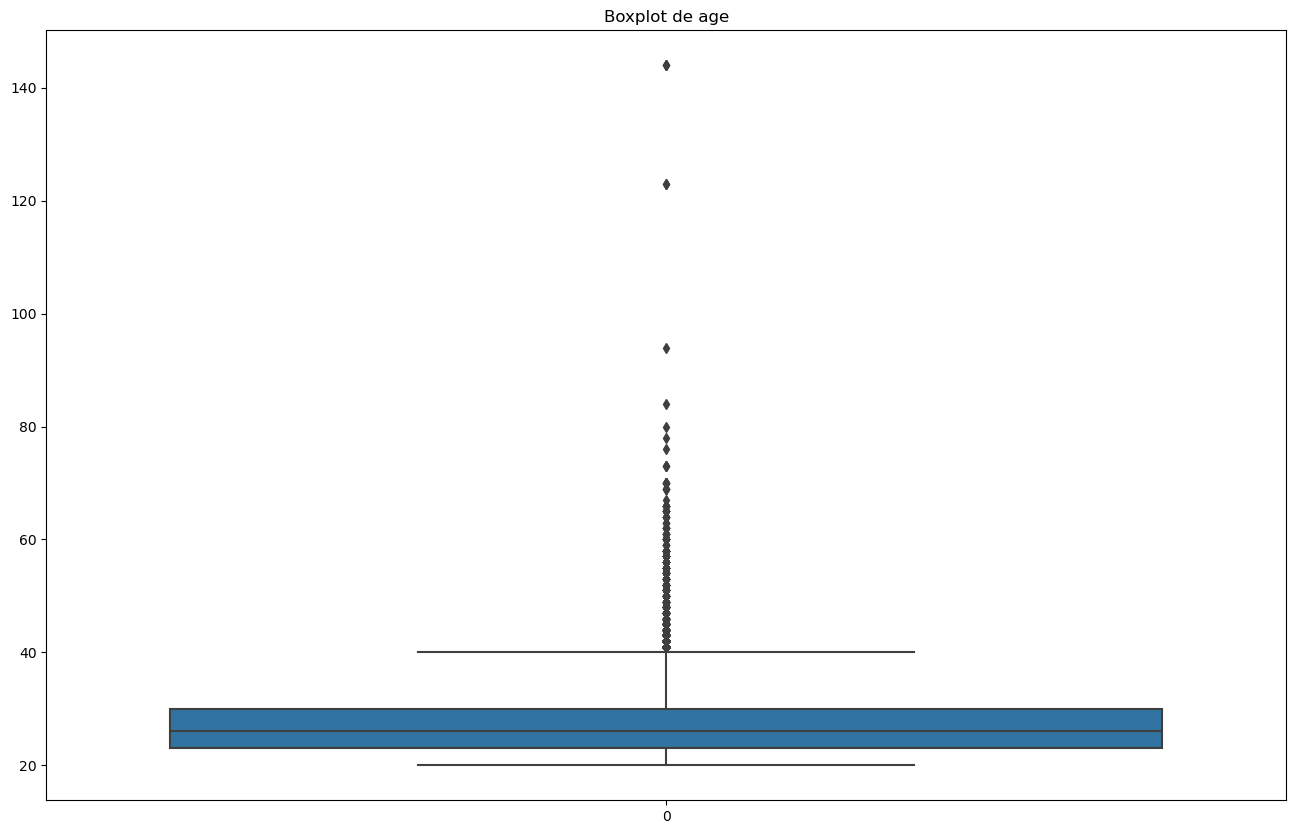

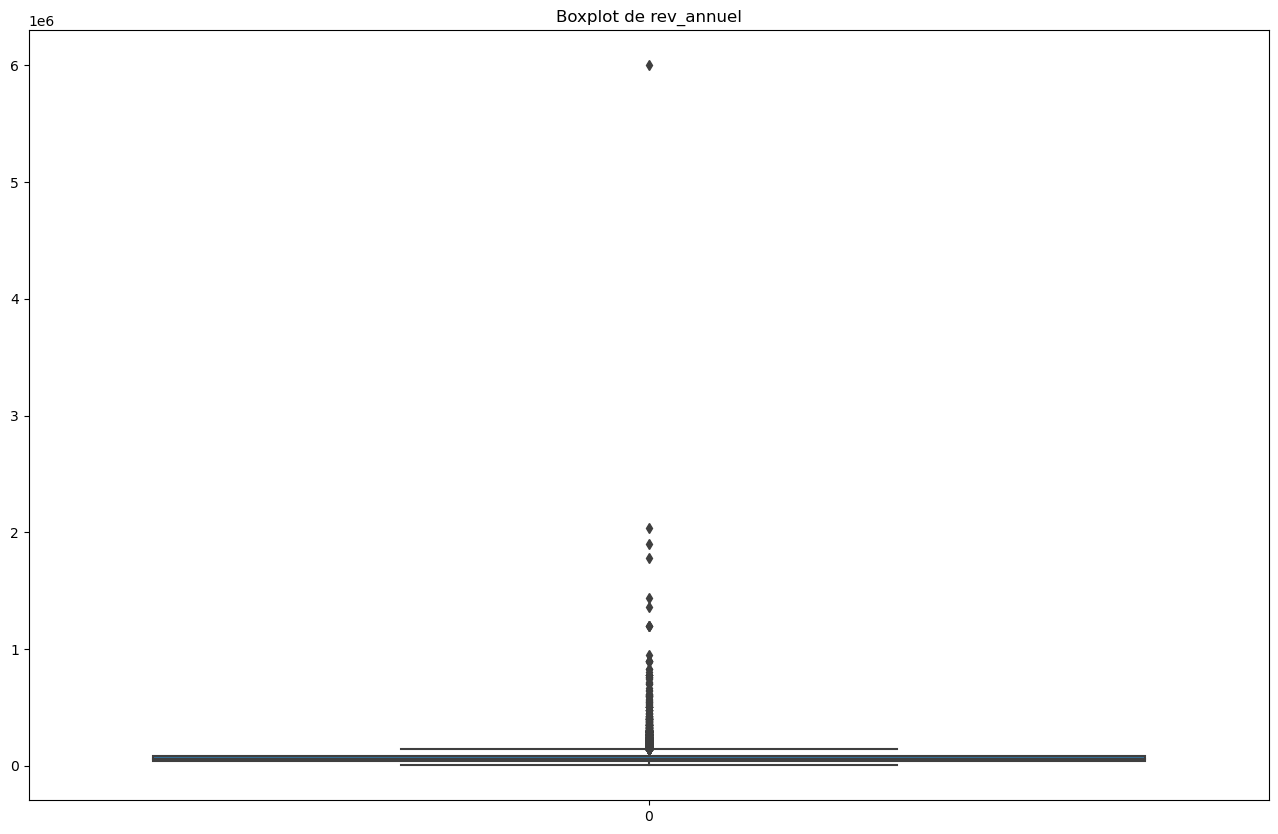

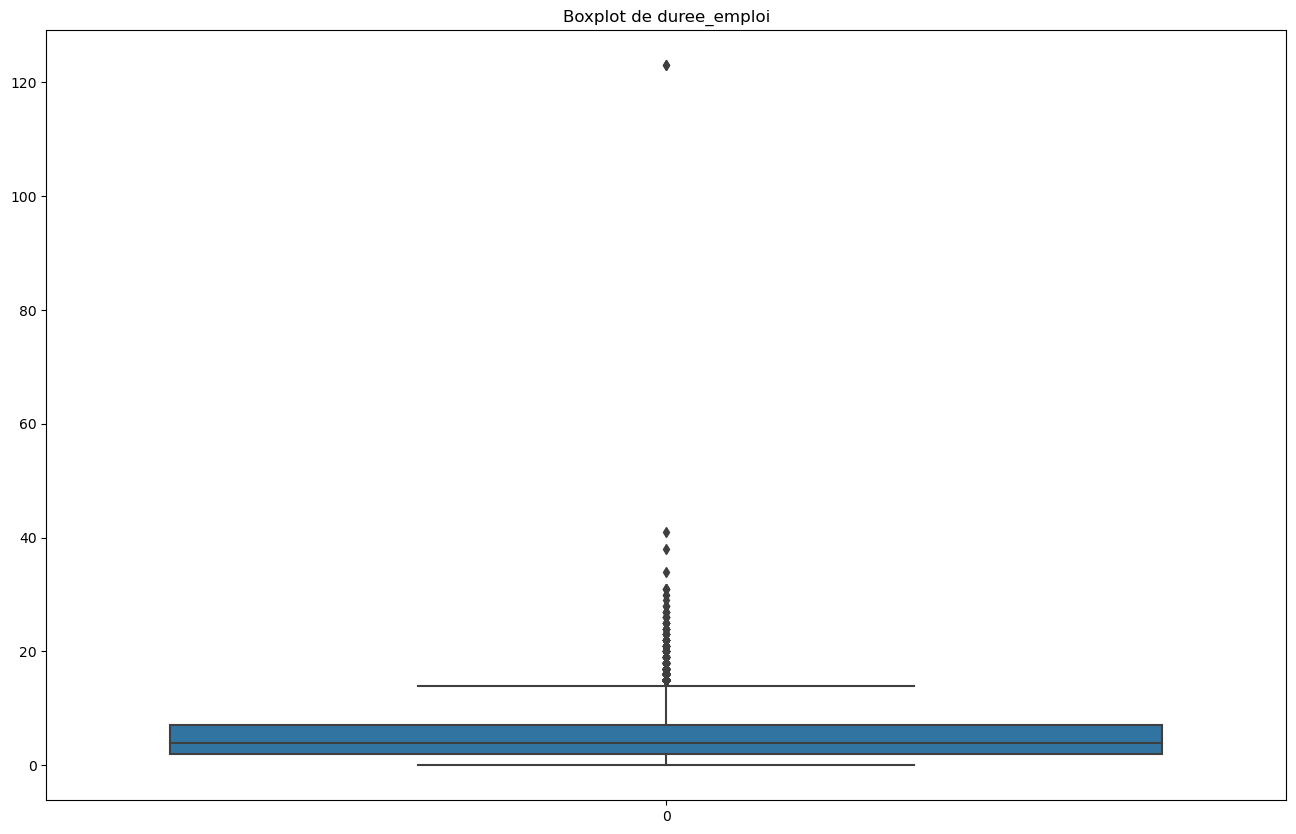

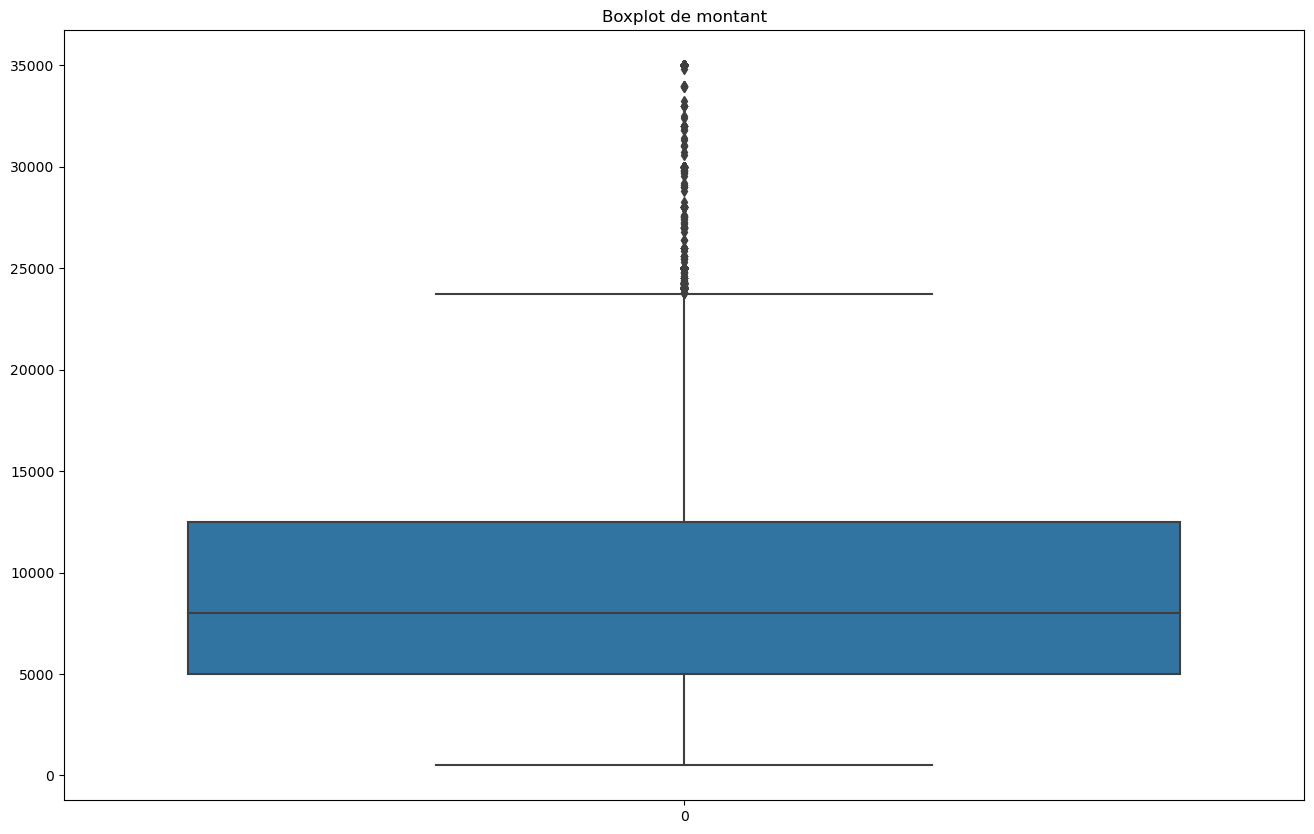

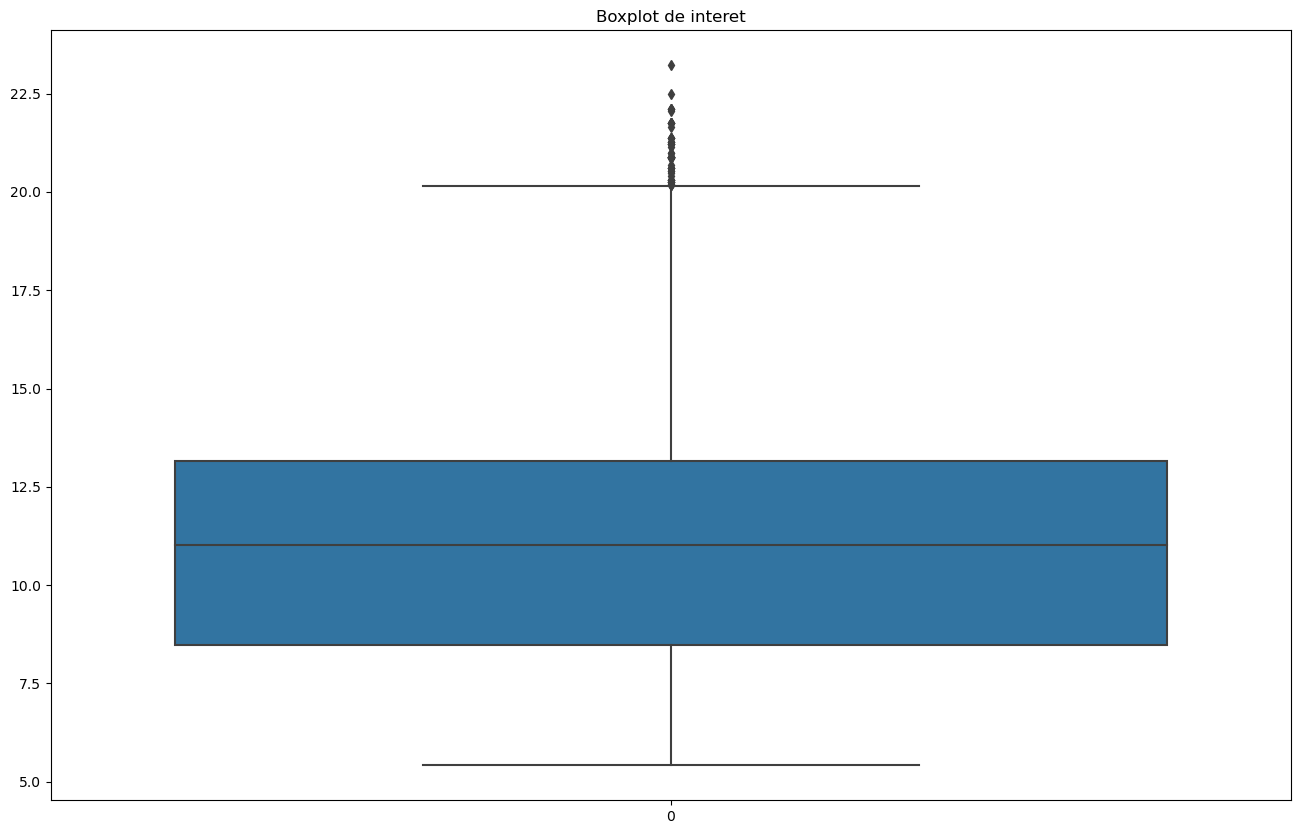

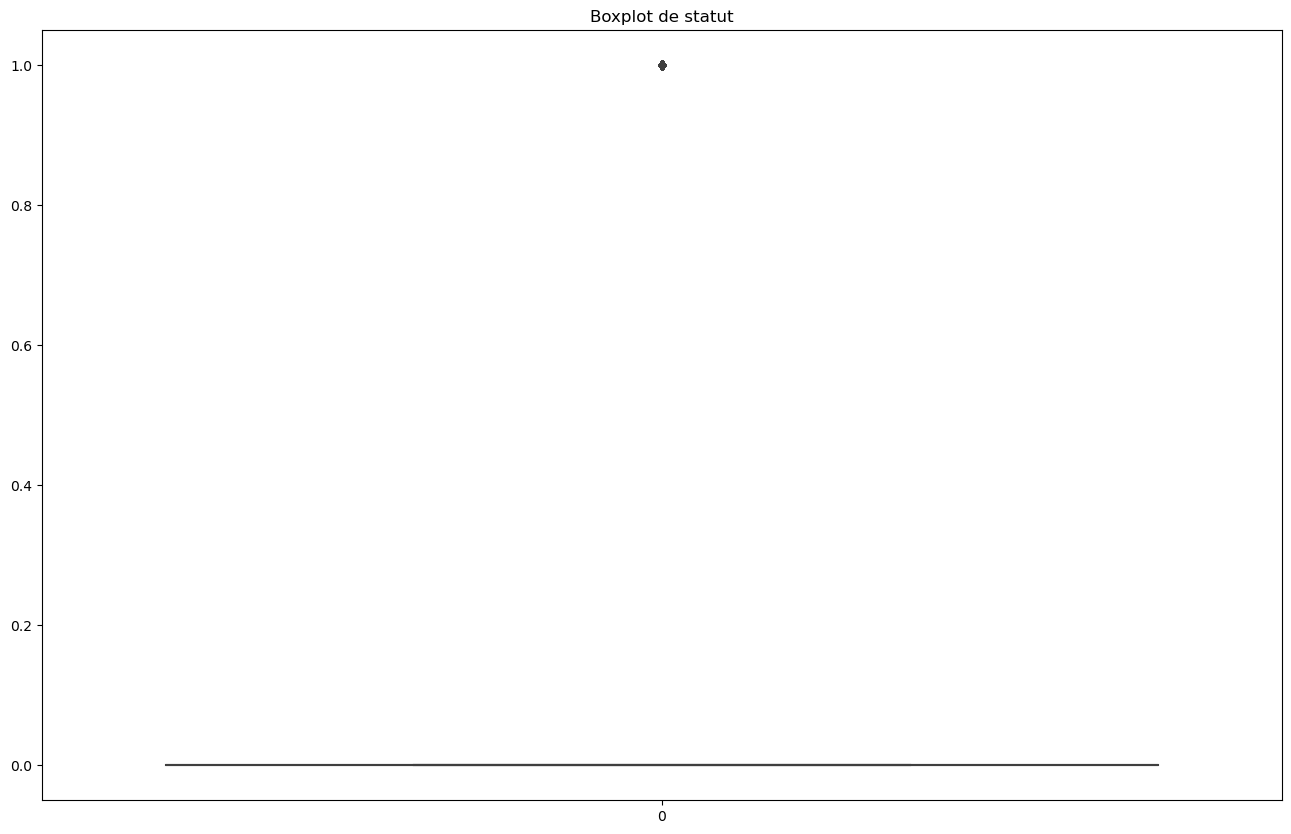

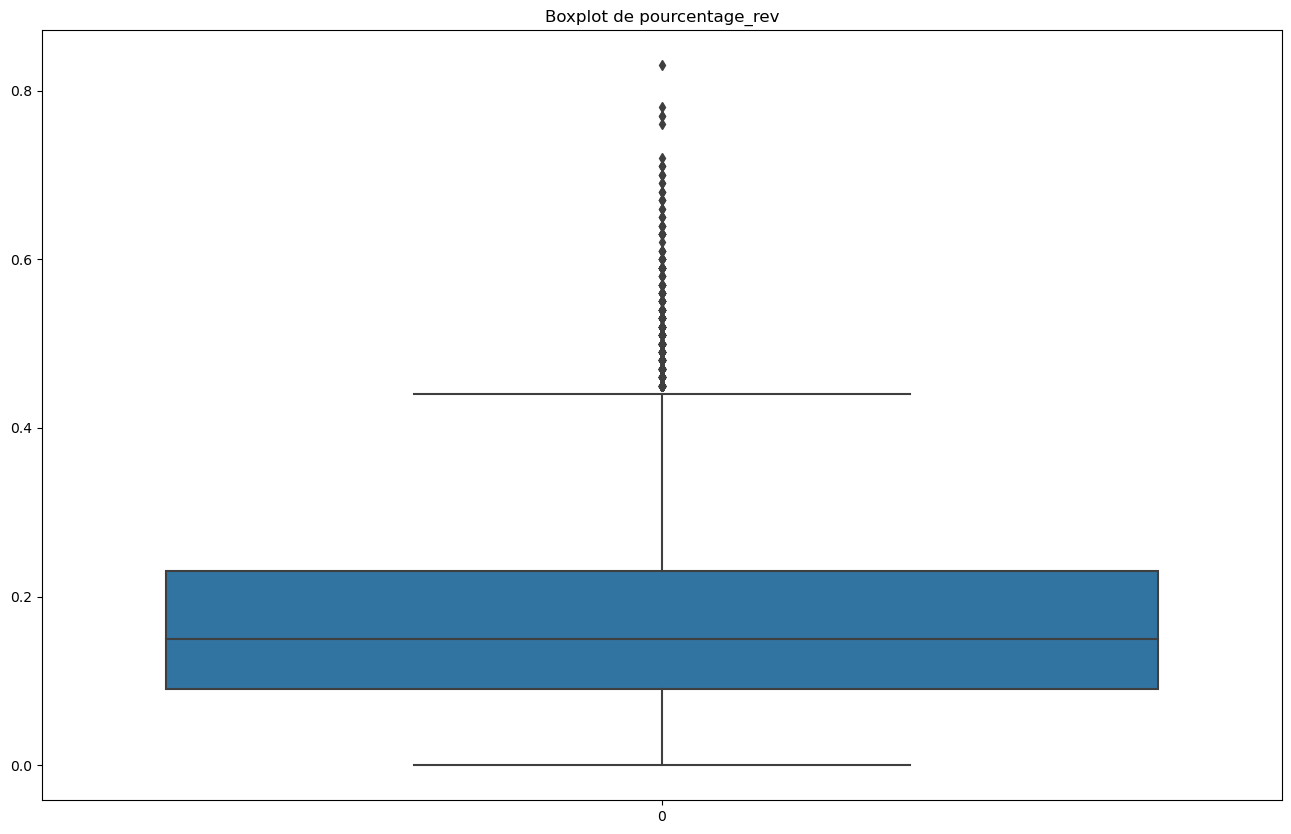

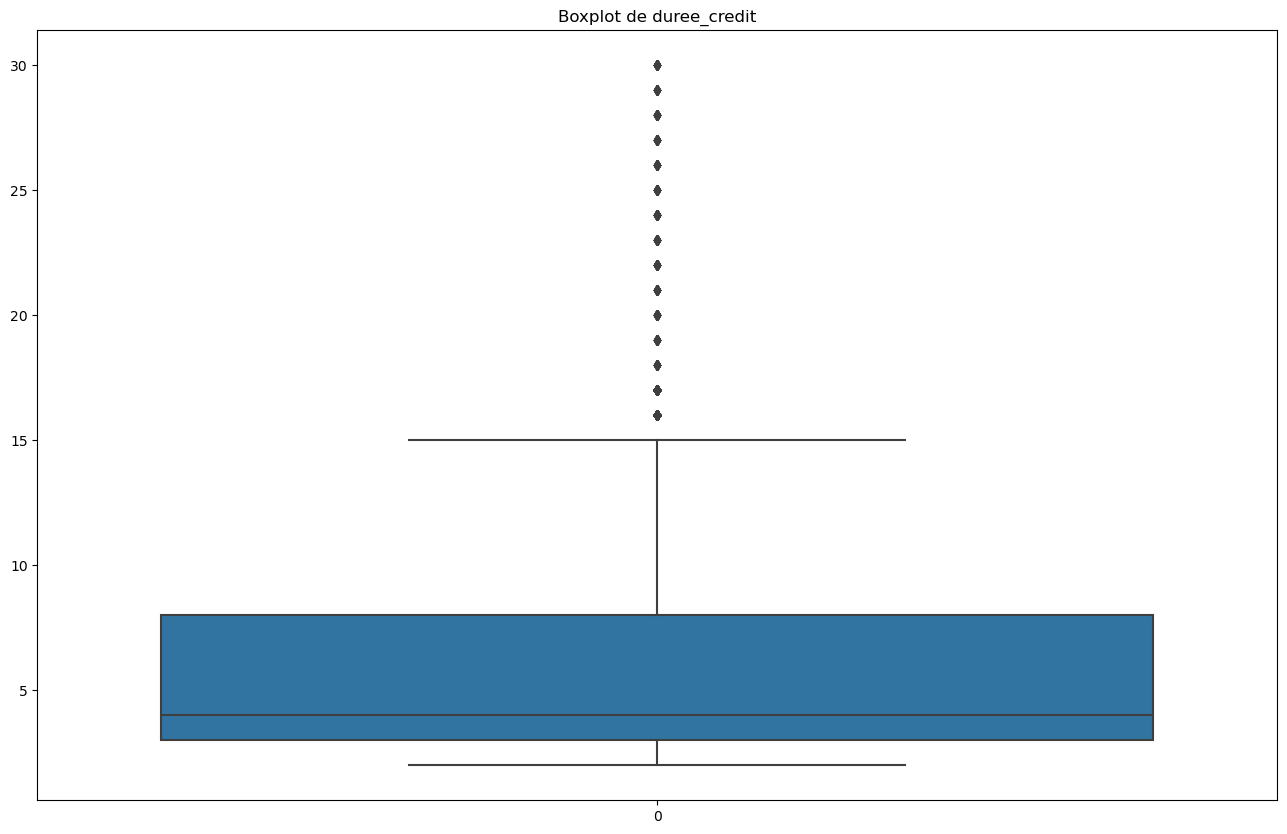

In [9]:
col_num = card.select_dtypes(include=["float64","int64"]).columns.to_list()
for col in col_num:
    fig, ax = plt.subplots(figsize = (16,10))
    sns.boxplot(card[col])
    ax.set_title(f"Boxplot de {col}")
    plt.show()

In [10]:

def outlier_corrector(df):
    # Sélectionner toutes les colonnes numériques (float64 et int64)
    col_num = df.select_dtypes(include=["float64", "int64"]).columns.to_list()
    
    for col in col_num:
        # Calcul du premier quartile (Q1) et du troisième quartile (Q3) pour déterminer les bornes
        q1 = df[col].quantile(0.25)  # Q1: 25% des valeurs
        q3 = df[col].quantile(0.75)  # Q3: 75% des valeurs
        iqr = q3 - q1  # Intervalle interquartile (distance entre Q3 et Q1)
        # Calcul des bornes (vmin et vmax) au-delà desquelles une valeur est considérée comme un outlier
        vmax = q3 + 1.5 * iqr  # Borne supérieure (Q3 + 1.5 * IQR)
        vmin = q1 - 1.5 * iqr  # Borne inférieure (Q1 - 1.5 * IQR)
        # Calcul de la médiane de la colonne pour remplacer les outliers
        moyenne = df[col].median()
        # Remplacement des valeurs en dehors des bornes (outliers) par la médiane
        df.loc[:, col] = df[col].apply(lambda x: moyenne if (x < vmin) or (x > vmax) else x)
    return df
for i in ["age", "duree_emploi", "montant", "rev_annuel", "interet", "pourcentage_rev", "duree_credit"]:
    card.loc[:, i] = outlier_corrector(card[[i]])

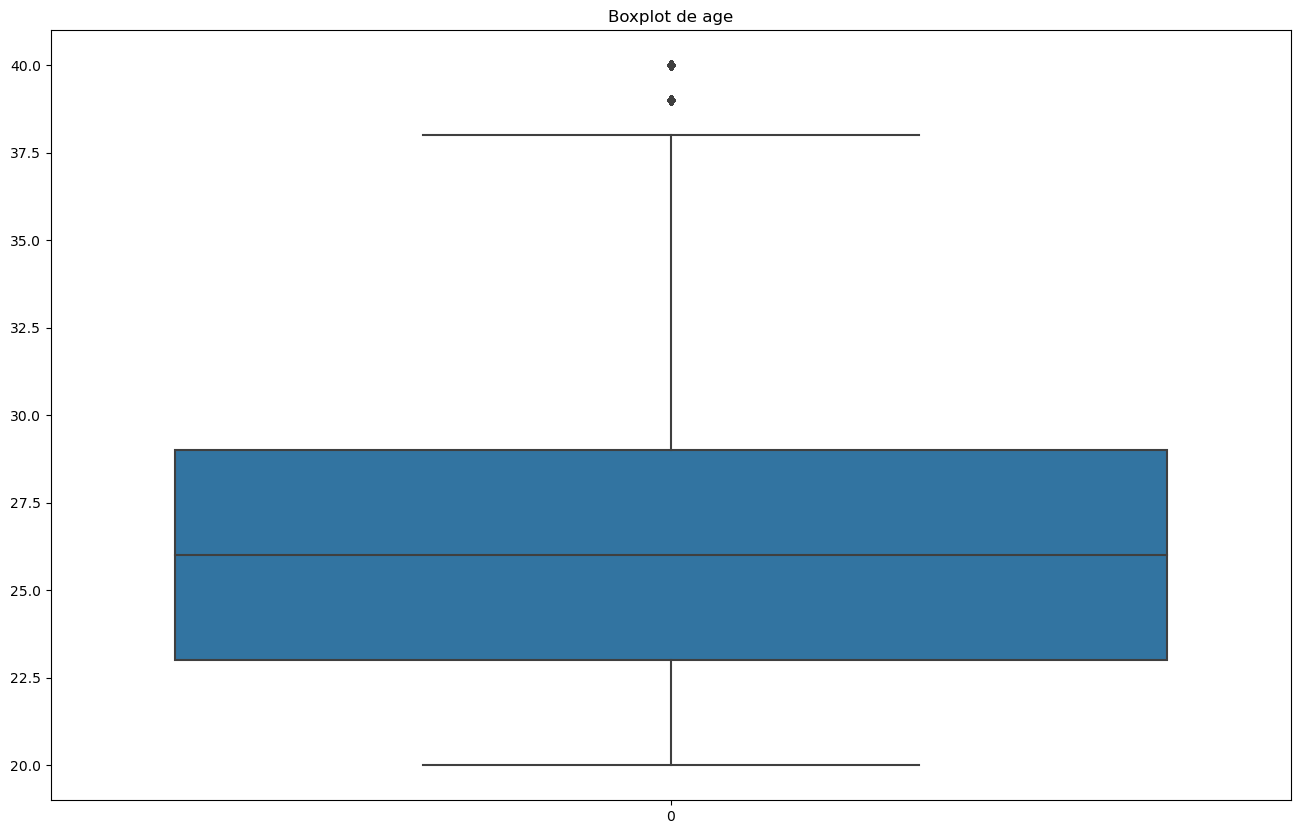

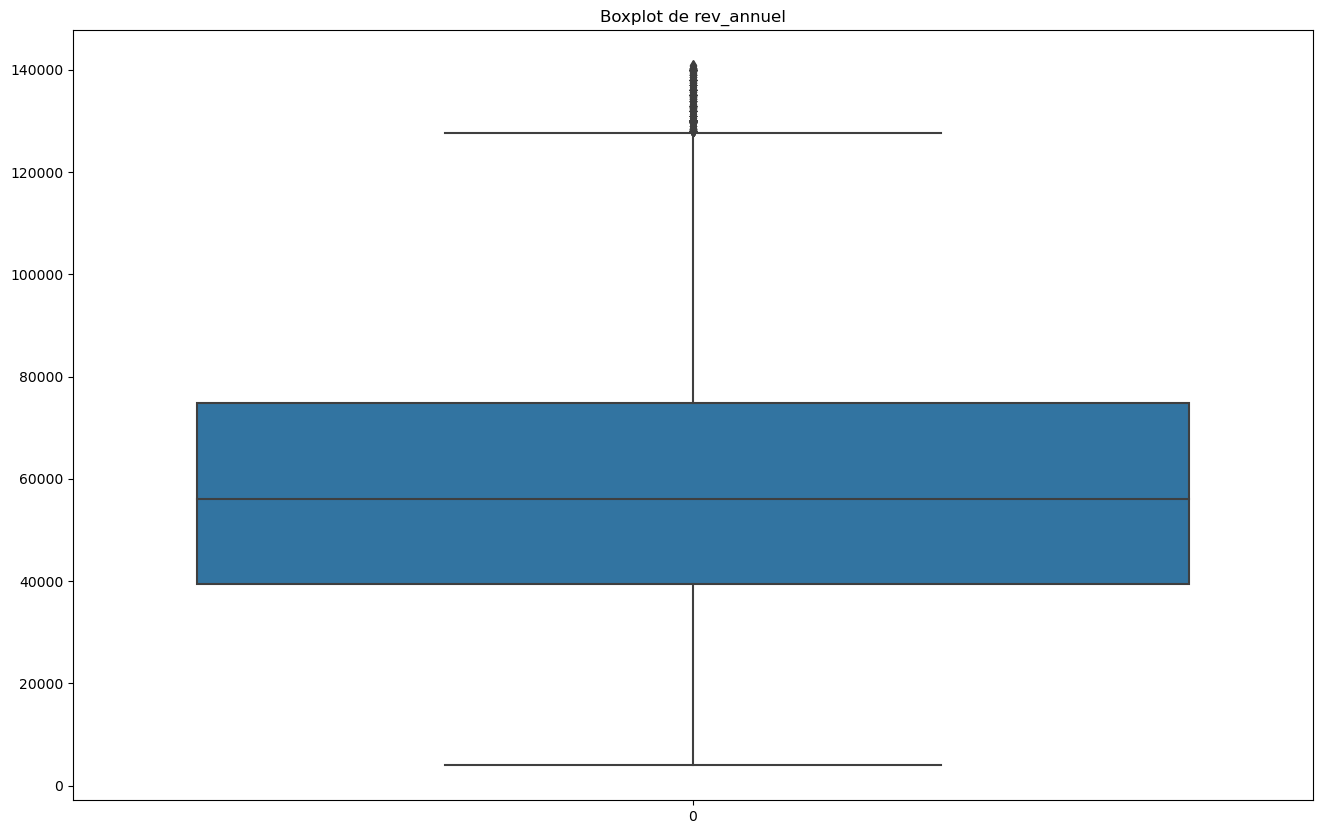

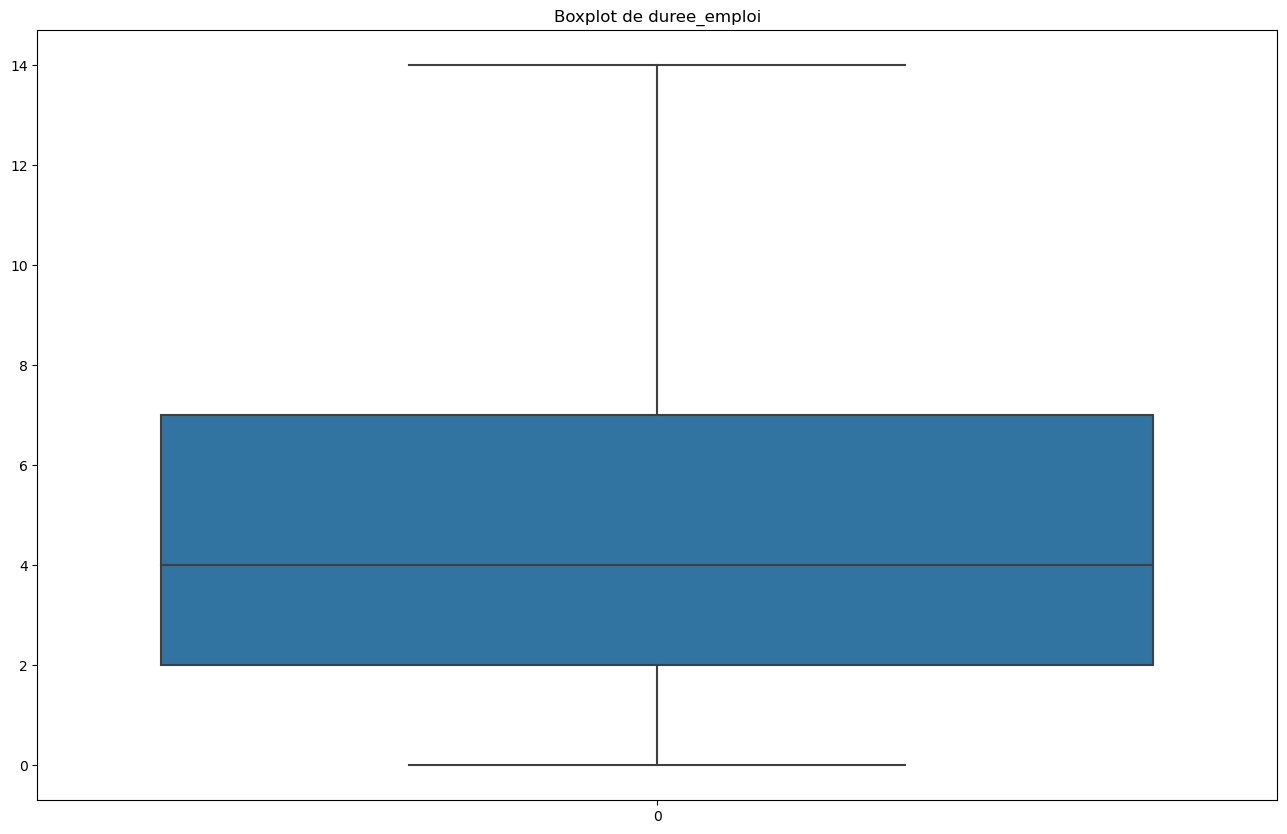

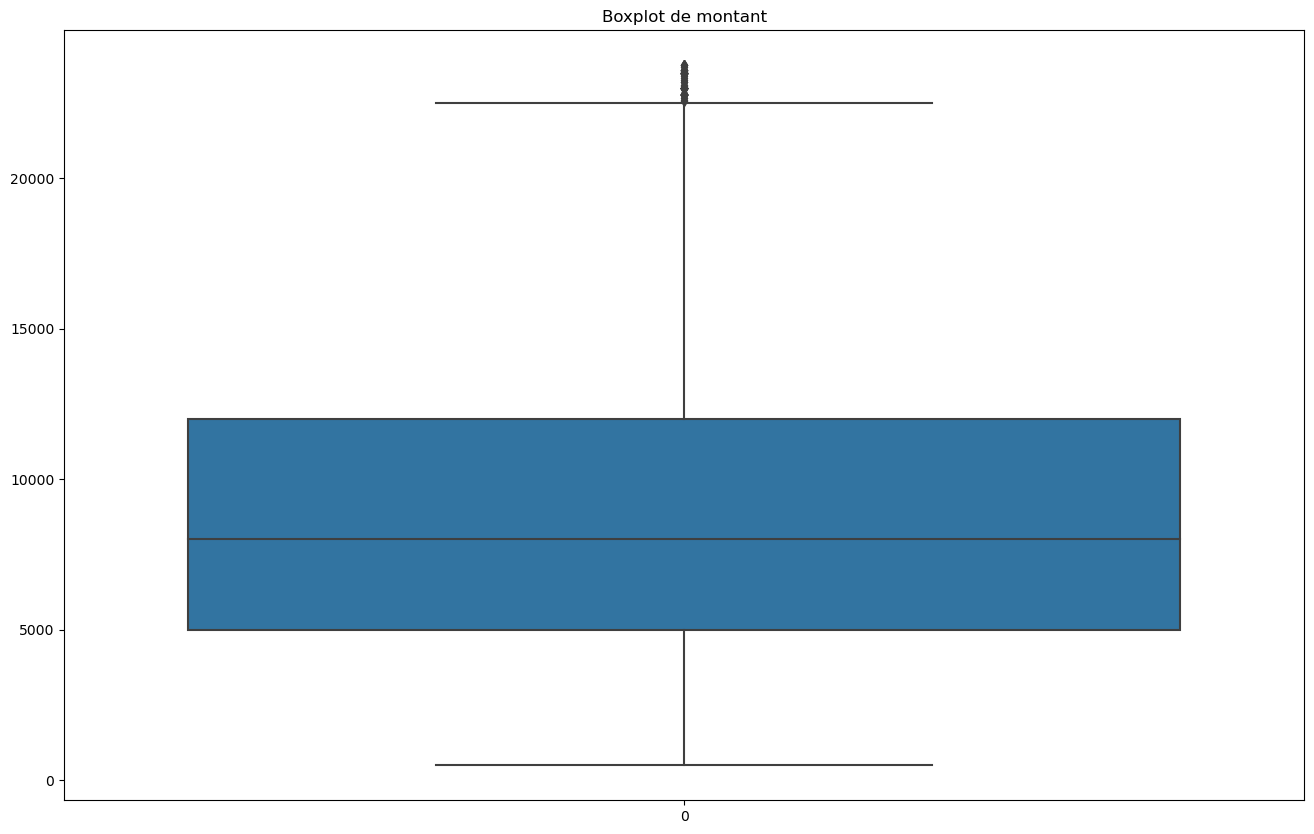

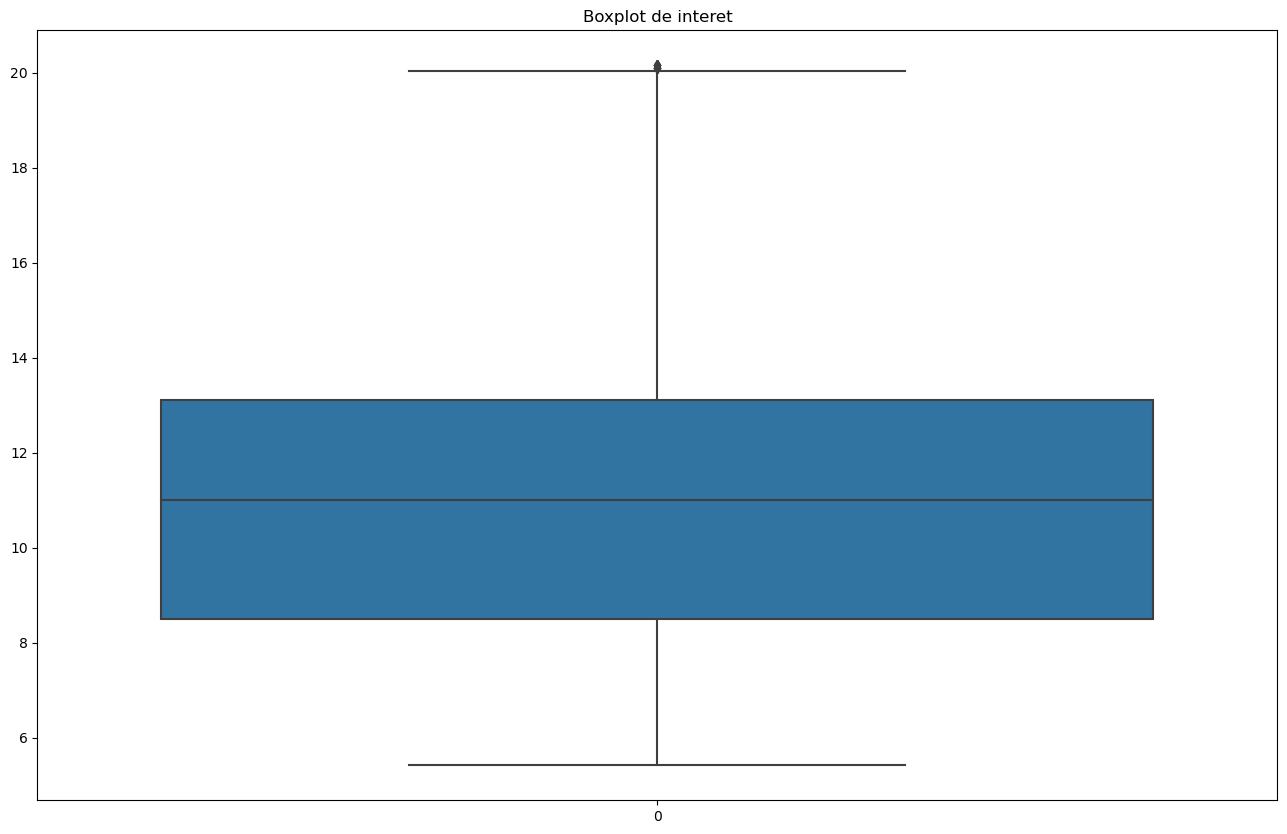

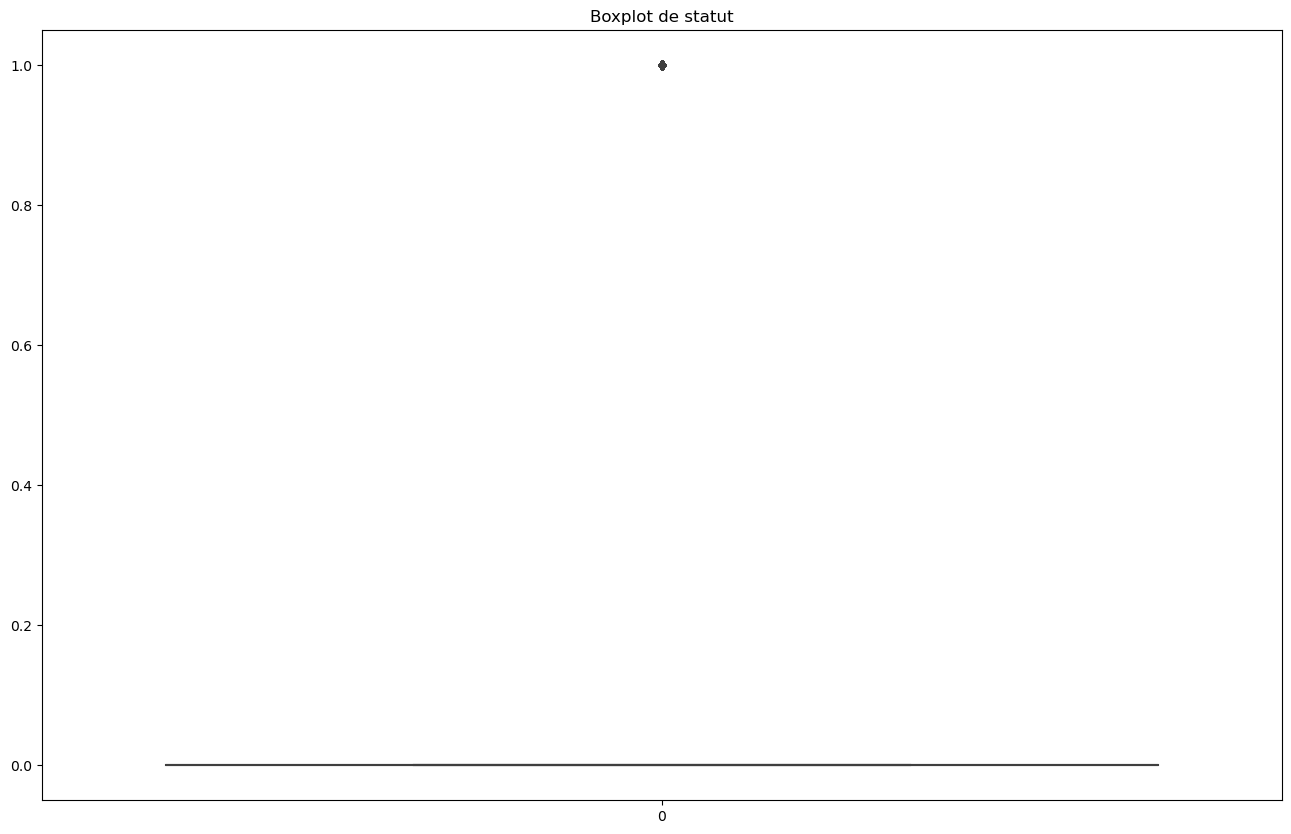

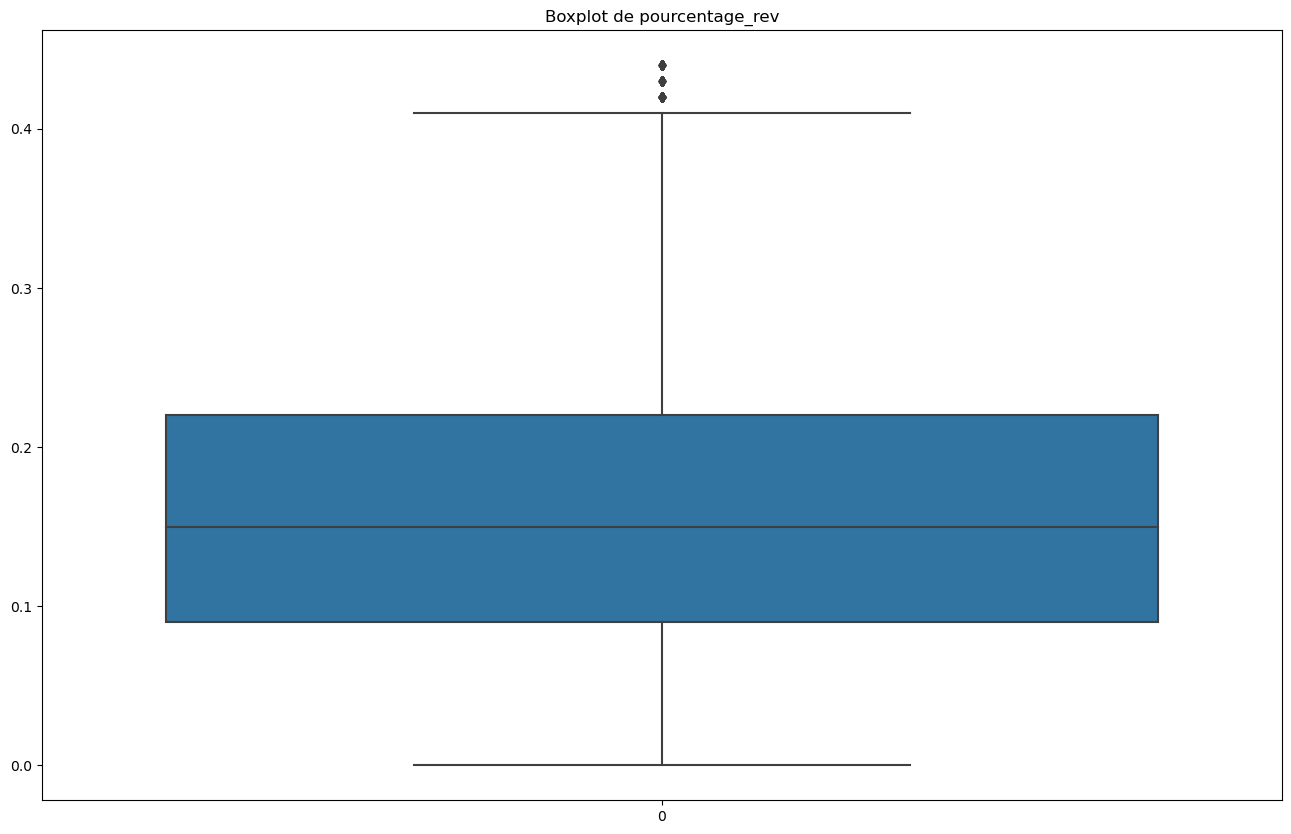

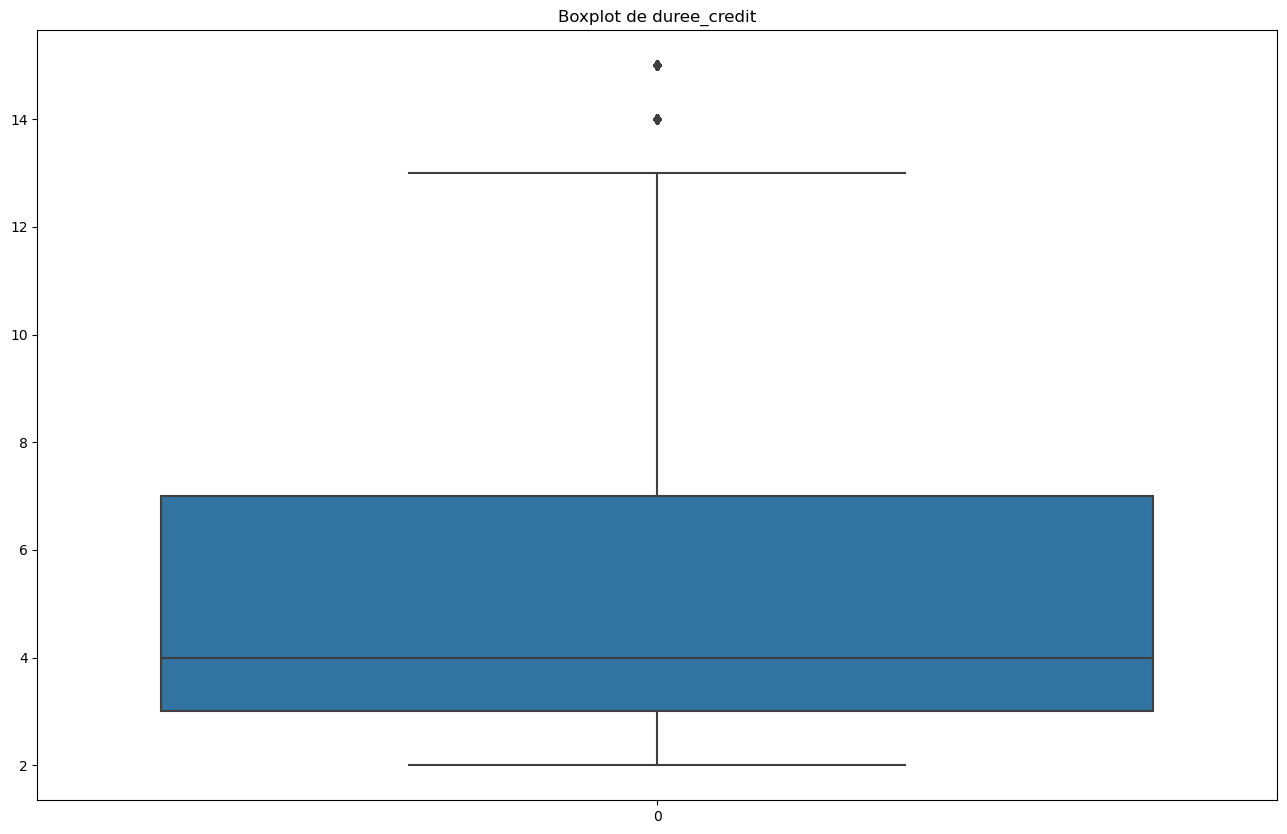

In [11]:
 # Visualisation après gestion des outliers
for col in col_num:
    fig, ax = plt.subplots(figsize = (16,10))
    sns.boxplot(card[col])
    ax.set_title(f"Boxplot de {col}")
    plt.show()

age n'est pas normalement distribuée, p_value : 0.0 et stat : 3818.386


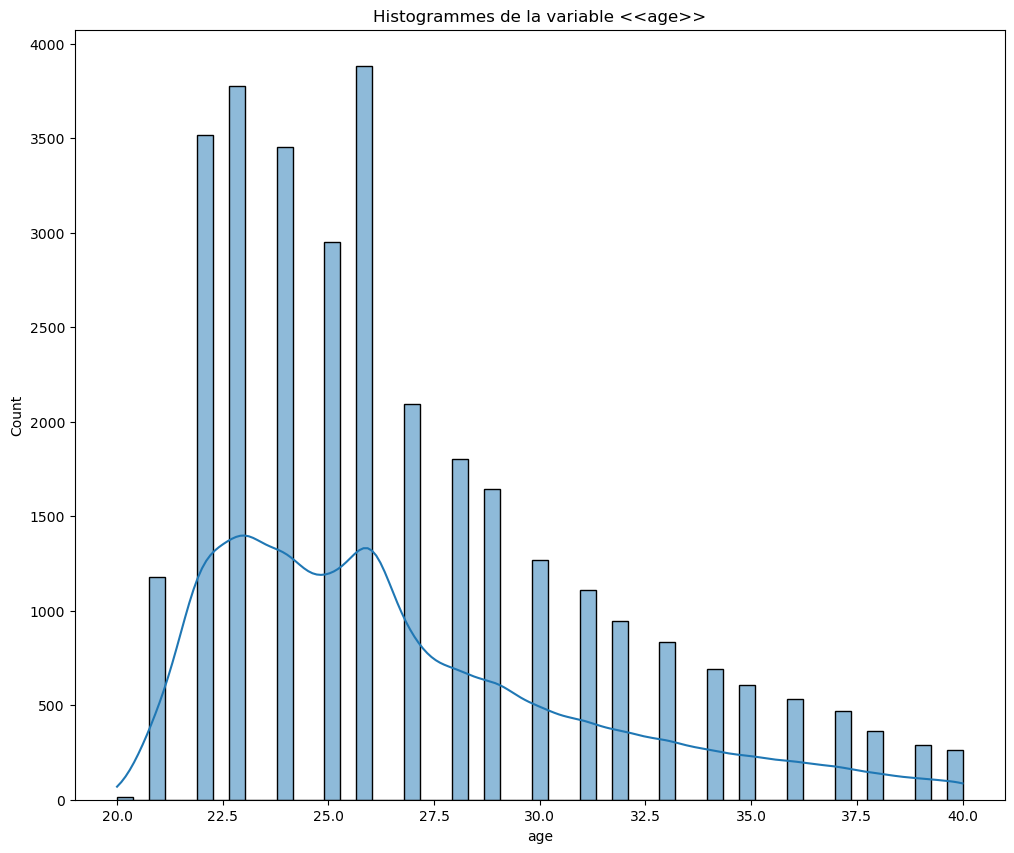

rev_annuel n'est pas normalement distribuée, p_value : 0.0 et stat : 2544.682


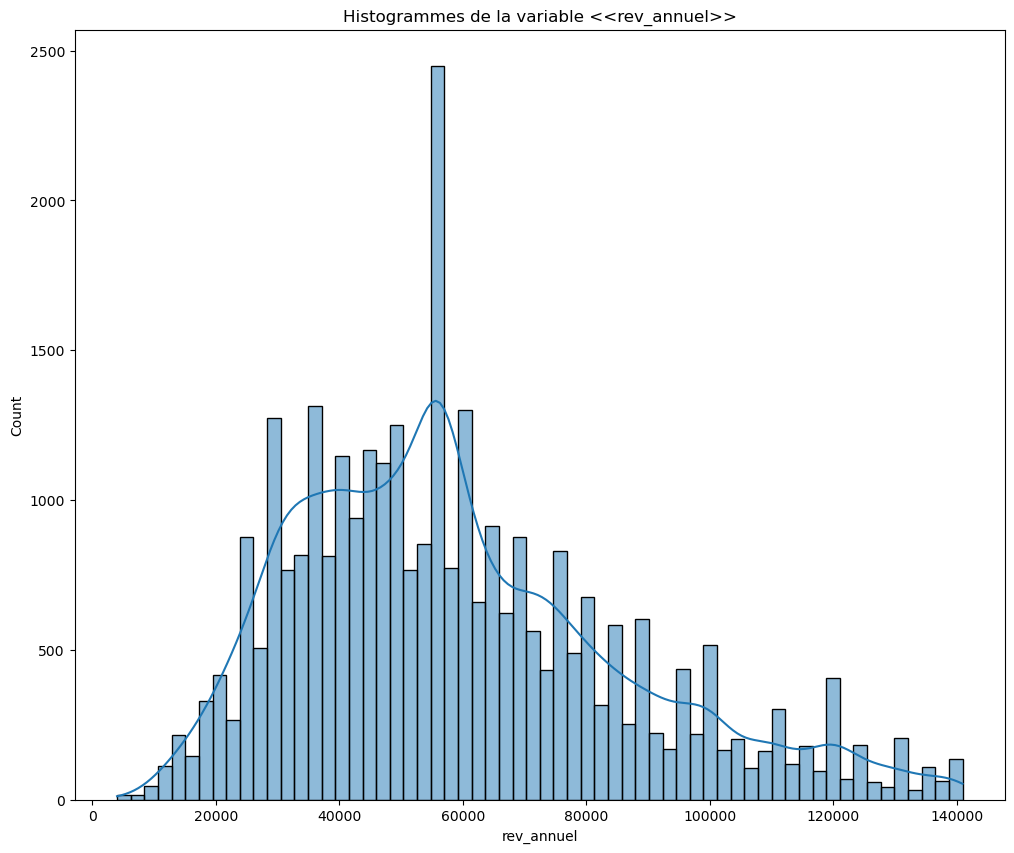

duree_emploi n'est pas normalement distribuée, p_value : 0.0 et stat : 2138.393


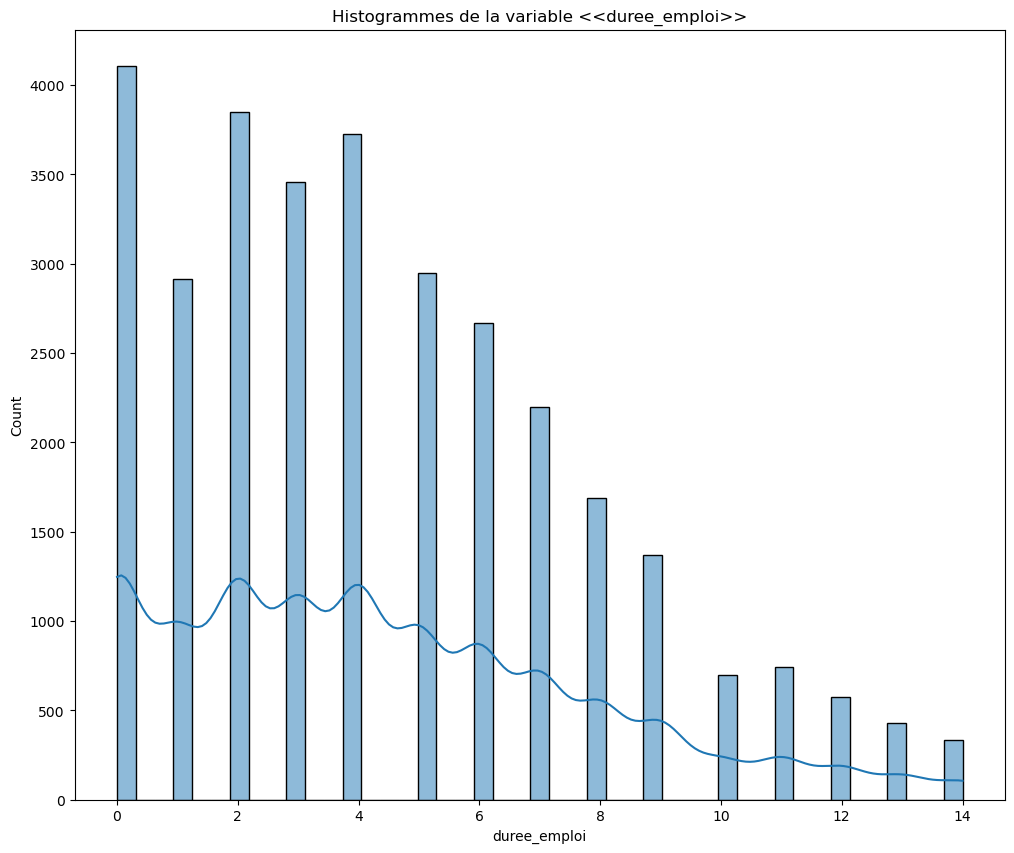

montant n'est pas normalement distribuée, p_value : 0.0 et stat : 2260.612


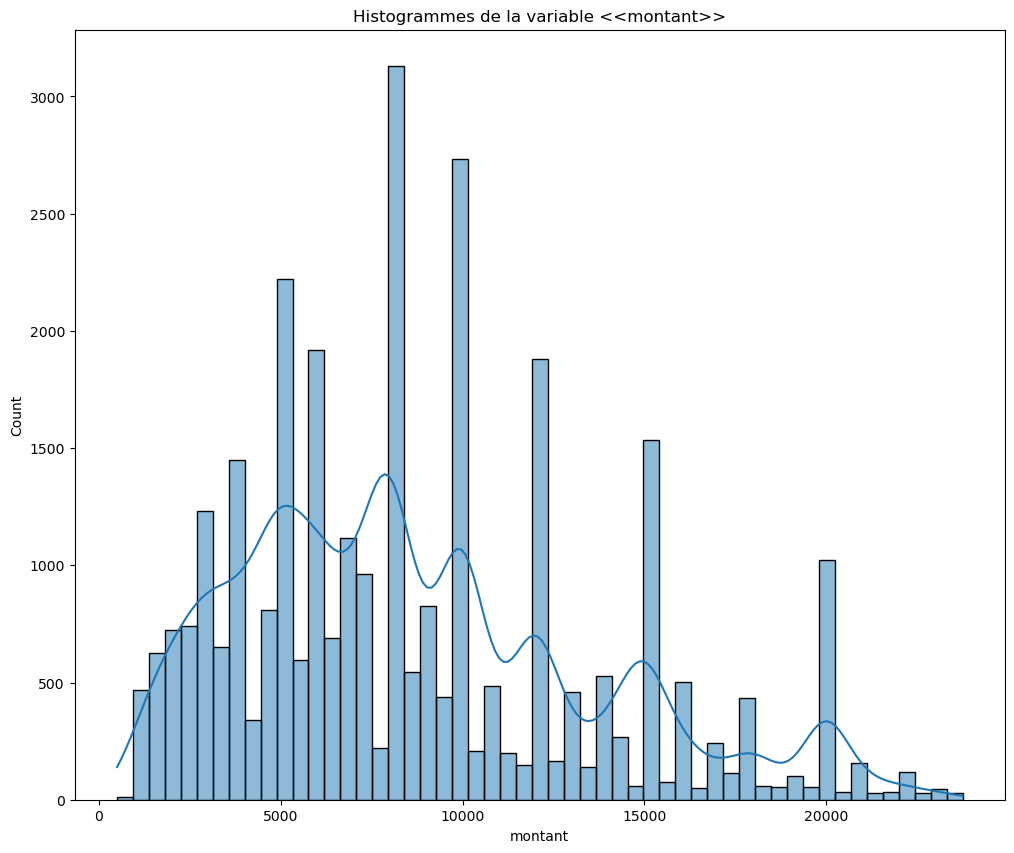

interet n'est pas normalement distribuée, p_value : 0.0 et stat : 848.009


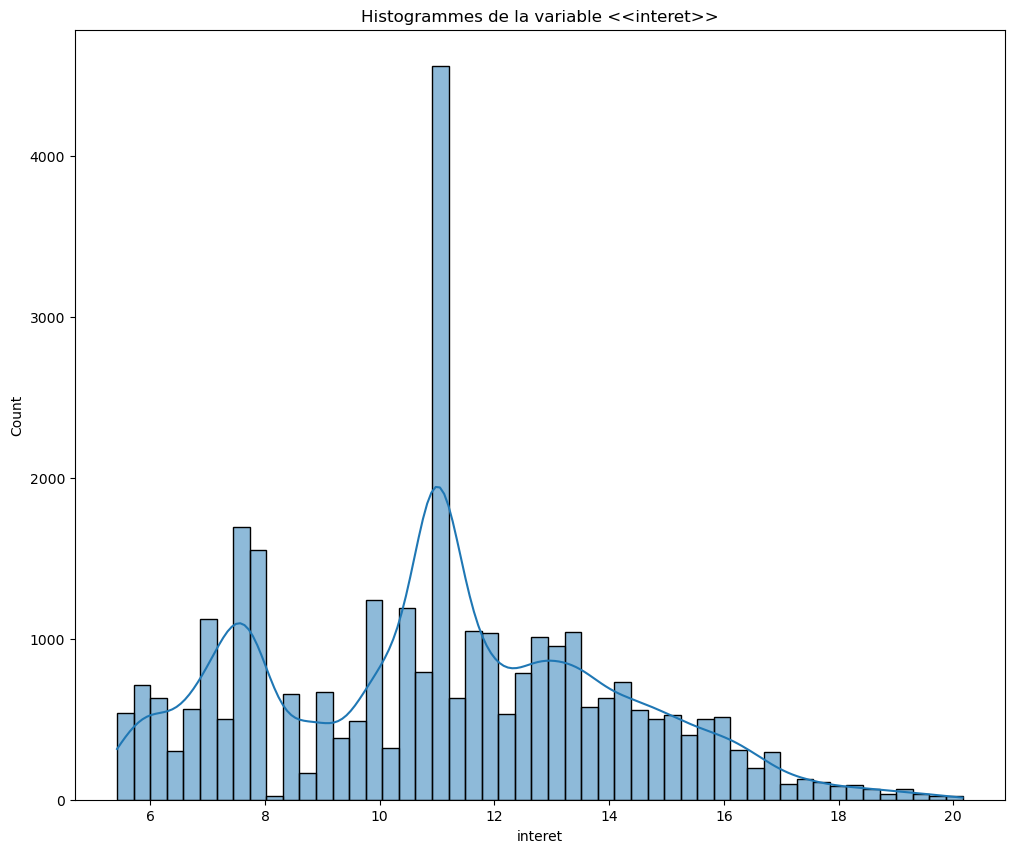

statut n'est pas normalement distribuée, p_value : 0.0 et stat : 5950.778


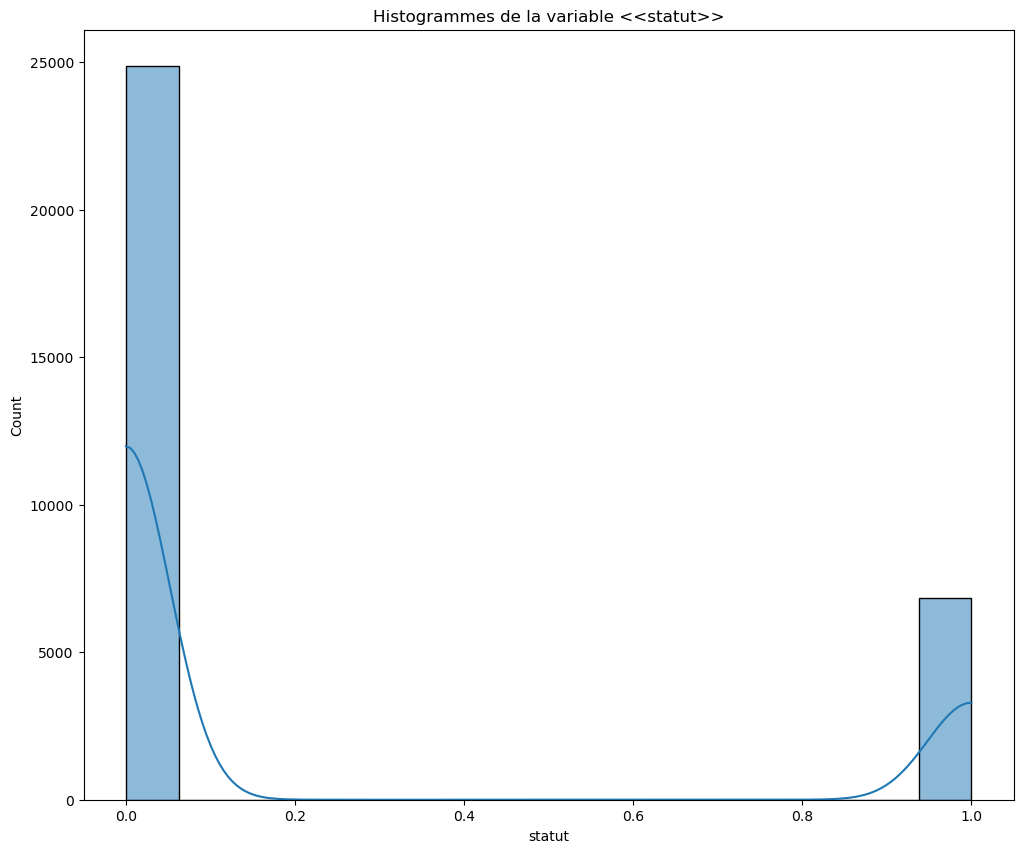

pourcentage_rev n'est pas normalement distribuée, p_value : 0.0 et stat : 2335.628


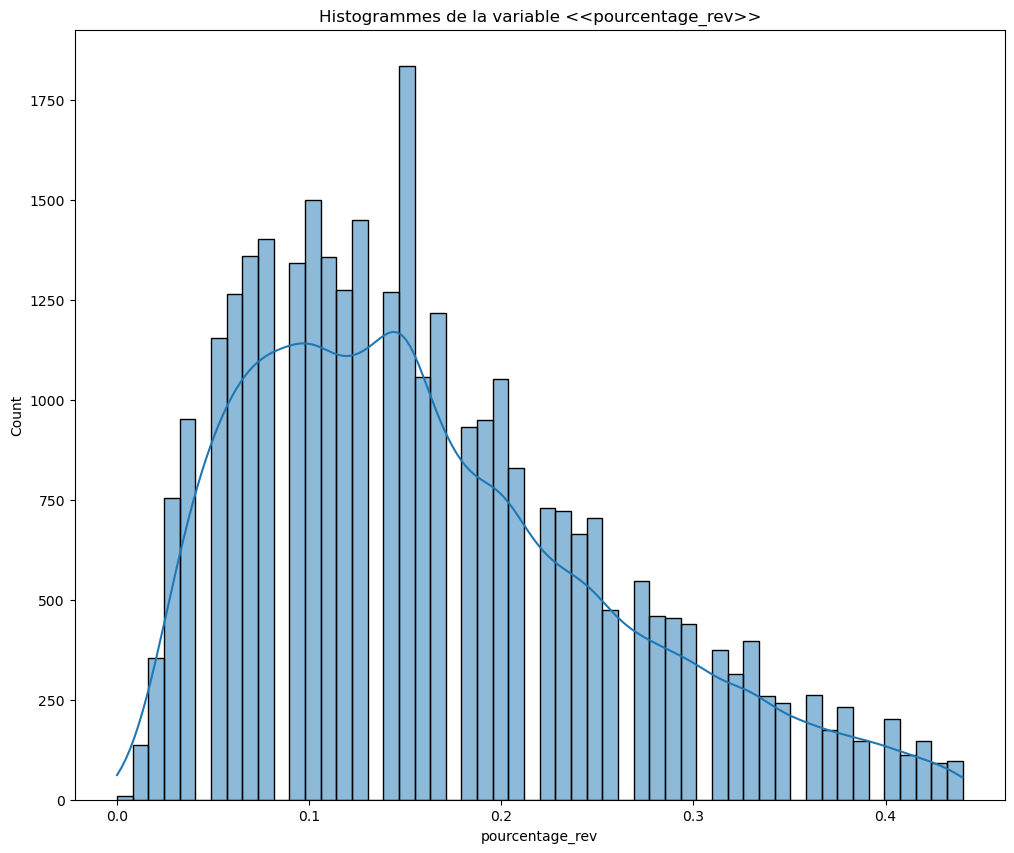

duree_credit n'est pas normalement distribuée, p_value : 0.0 et stat : 4455.532


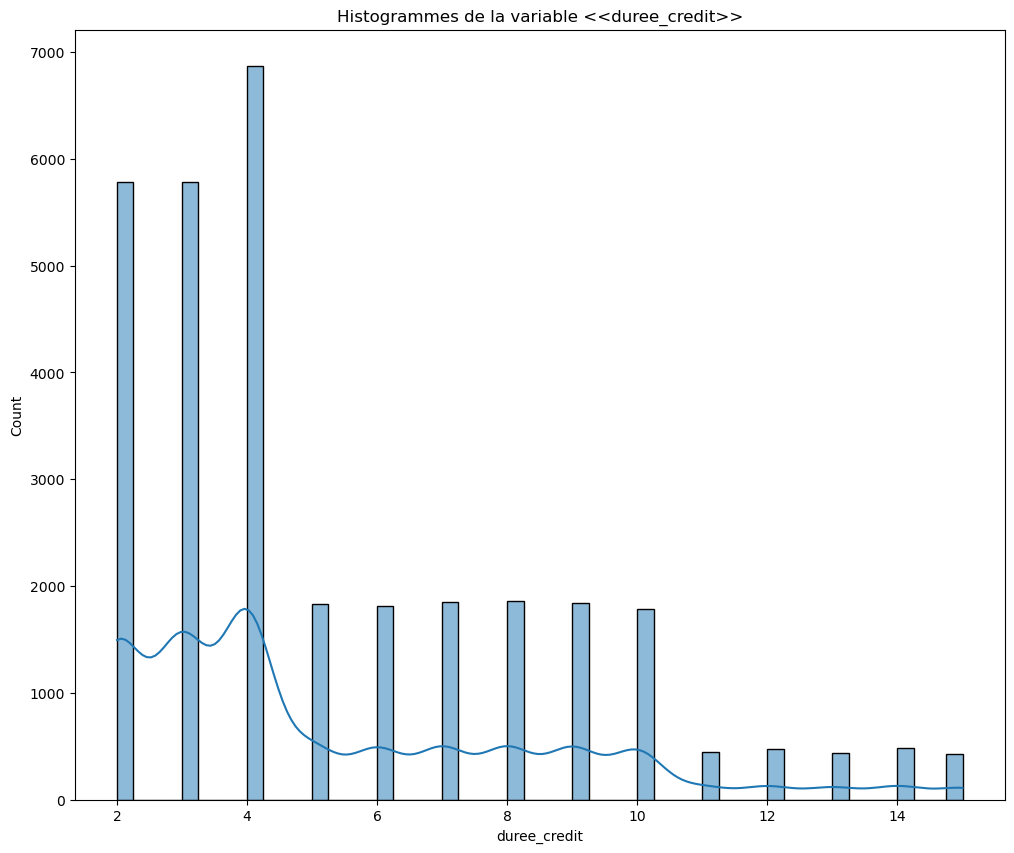

In [12]:
 # Fonction de Test de normalité

def normal_test(df):
    
    col_num = df.select_dtypes(include=["float64", "int64"]).columns.to_list()
   
    for col in col_num:
        
        fig, ax = plt.subplots(figsize=(12, 10))
        # Application du test de normalité d'Anderson-Darling pour vérifier si la distribution est normale
        statistic, pvalue = stat.normaltest(df[col])
        ax.set_title(f"Histogrammes de la variable <<{col}>>")
        sns.histplot(data=df, x=col, kde=True)
        # Si la p-value est inférieure à 0.05, cela signifie que la variable n'est pas normalement distribuée
        if pvalue < 0.05:
            print(f"{col} n'est pas normalement distribuée, p_value : {round(pvalue, 3)} et stat : {round(statistic, 3)}")
        else:
            # Si la p-value est supérieure ou égale à 0.05, cela signifie que la variable suit une distribution normale
            print(f"{col} est normalement distribuée")
        
        plt.show()

normal_test(card)


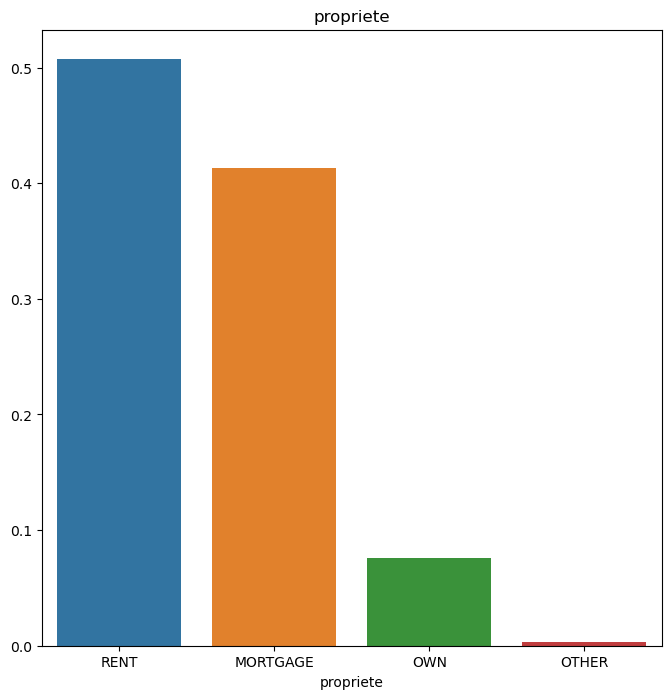

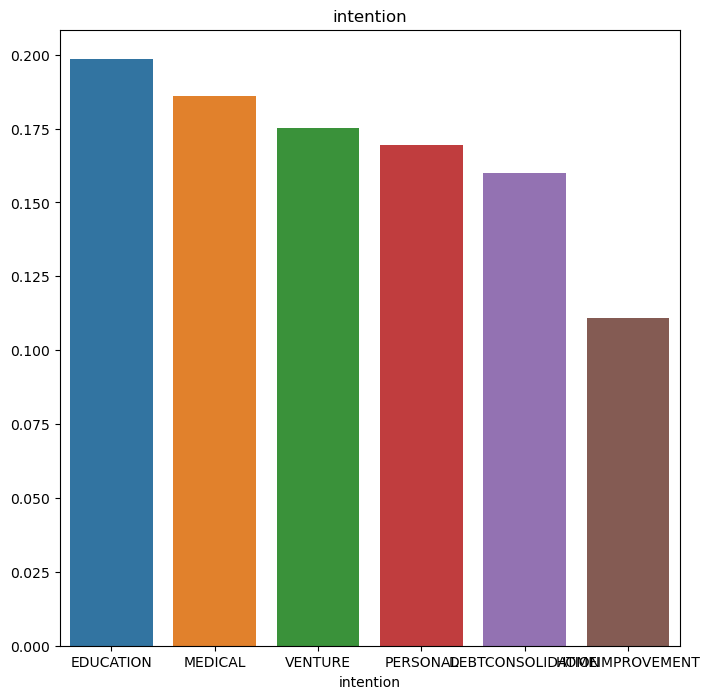

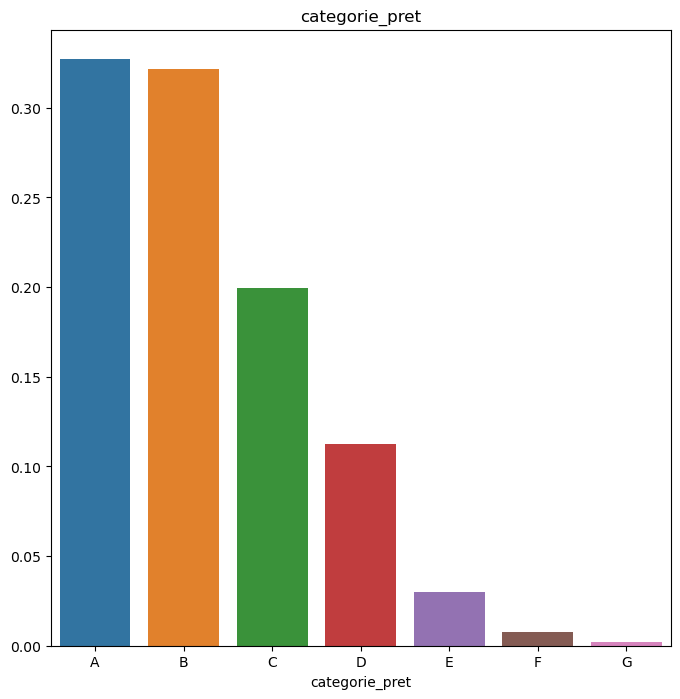

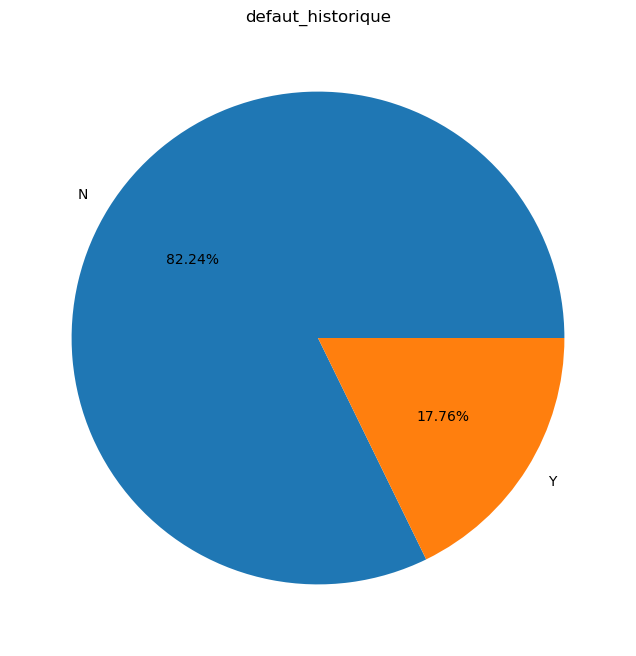

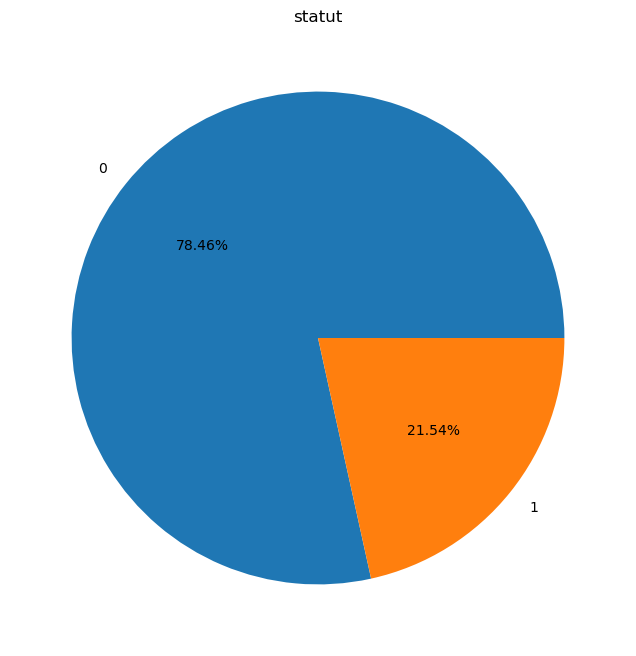

In [13]:
# Fonction d'analyse qualitative des variables
def var_quality(df):
    col_object = df.select_dtypes(include=["object"]).columns.to_list()
    col_object.append('statut')
    for j in col_object:
        tab = (df[j].value_counts()) / len(df)
        fig, ax = plt.subplots(figsize=(8, 8))
        if len(tab.index) <= 3:
            plt.pie(tab, autopct="%.2f%%", labels=tab.index)
            ax.set_title(f"{j}")  
            plt.show() 
        # Si le nombre de modalités est supérieur à 3, utiliser un diagramme à barres
        else:
            # Affichage d'un diagramme à barres
            sns.barplot(x=tab.index, y=tab.values)
            ax.set_title(f'{j}')  # Titre du graphique
            plt.show()  # Affichage du graphique


var_quality(card)


# 2 2. Analyse BIVARIEE

In [14]:
#sns.pairplot(data=card)
#plt.show()

<Axes: title={'center': 'Carte thermique des corrélations entre les variables'}>

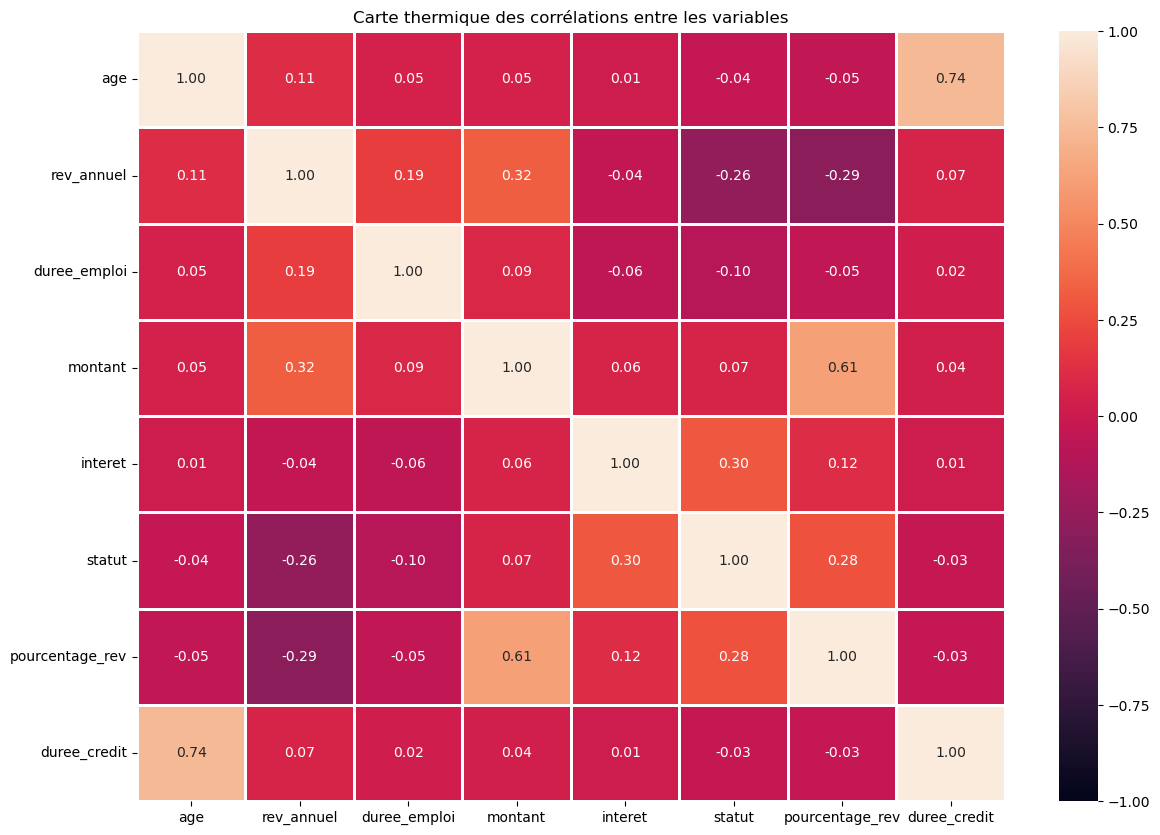

In [15]:
# Calcul de la matrice de corrélation entre les variables numériques
corr_coef = card.select_dtypes(include=["int64", "float64"]).corr(method="spearman")
# Création d'un masque pour ne conserver que la moitié supérieure de la matrice (triangle supérieur)
masque = np.triu(np.zeros_like(corr_coef, dtype=bool))
plt.figure(figsize=(14, 10))
plt.title("Carte thermique des corrélations entre les variables")
sns.heatmap(data=corr_coef, mask=masque, linewidths=1, vmax=1, vmin=-1, fmt='.2f', annot=True)


In [16]:
# Boucle sur toutes les colonnes de type 'object' (variables catégorielles) et sur la colonne 'statut'
for i in card.select_dtypes(include=["object"]).columns.to_list() + ["statut"]:
    for j in card.select_dtypes(include=["object"]).columns.to_list() + ["statut"]:  
        # On ne calcule pas la table de contingence pour les paires de variables identiques (i == j)
        if i != j:
            # Création du tableau de contingence entre les variables 'i' et 'j'
            crosstab = pd.crosstab(card[i], card[j])
            
            # Test du chi carré pour tester l'indépendance entre les deux variables
            statistic, pvalue, ddl, freq = stat.chi2_contingency(crosstab)
            
            # Si la p-value est inférieure à 0.05, on rejette l'hypothèse d'indépendance
            if pvalue < 0.05:
                text = f"Les deux variables ne sont pas indépendantes avec p-value {round(pvalue, 3)}"
            else:
                text = f"Les deux variables sont indépendantes avec p-value {round(pvalue, 3)}"
            
            # Affichage de la table de contingence
            print(crosstab)
            # Affichage du résultat du test du chi carré
            print(text)

intention  DEBTCONSOLIDATION  EDUCATION  HOMEIMPROVEMENT  MEDICAL  PERSONAL  \
propriete                                                                     
MORTGAGE                2239       2559             1699     2132      2276   
OTHER                     17         17               12       17        18   
OWN                       68        489              300      405       414   
RENT                    2740       3225             1499     3343      2661   

intention  VENTURE  
propriete           
MORTGAGE      2188  
OTHER           26  
OWN            734  
RENT          2608  
Les deux variables ne sont pas indépendantes avec p-value 0.0
categorie_pret     A     B     C     D    E    F   G
propriete                                           
MORTGAGE        5256  3959  2221  1192  338   96  31
OTHER             26    34    17    20    8    2   0
OWN              832   760   475   271   54   13   5
RENT            4257  5433  3608  2073  552  125  28
Les deux variables 

**Tableaux de contingence :**

**Un tableau de contingence résume les fréquences des différentes combinaisons de catégories entre deux variables catégorielles. Par exemple, si tu as deux variables comme age (qui peut être catégorisé en tranches d'âge) et statut (qui pourrait être "approuvé" ou "refusé"), un tableau de contingence afficherait le nombre d'individus dans chaque catégorie combinée (par exemple, combien de personnes de 18 à 25 ans ont été approuvées, combien ont été refusées, etc.)**.

**Test du chi carré :**

**Le test du chi carré sert à déterminer s'il existe une relation significative entre deux variables catégorielles. Si la p-value est faible (généralement inférieure à 0,05), cela suggère que les deux variables sont dépendantes, c'est-à-dire qu'il y a une association entre elles. En revanche, une p-value élevée suggère qu'il n'y a pas de relation significative et que les variables sont**

# 3. ANALYSE MULTI VARIEE AVEC PCA

In [17]:

# On définit la liste des variables catégorielles à encoder
col_encoded = ["propriete", "intention", "categorie_pret", "defaut_historique"]

# Utilisation de pd.get_dummies() pour encoder les variables catégorielles sous forme de variables binaires (0 ou 1)
# Cela va créer de nouvelles colonnes, une pour chaque catégorie de chaque variable
card_encoded = pd.get_dummies(card[col_encoded], dtype=int)

# Concaténation des colonnes encodées avec le DataFrame d'origine
card_norm = pd.concat([card, card_encoded], axis=1)

# Suppression des anciennes colonnes catégorielles du DataFrame
# Les anciennes variables catégorielles sont désormais redondantes après encodage
for i in col_encoded:
    del card_norm[i]

## Normalisation
# Liste des variables numériques à normaliser
col_norm = ["age", "rev_annuel", "duree_emploi", "montant", "interet", "duree_credit"]

# Appliquer la normalisation : (x - mean) / std
# Cela met chaque variable sur une échelle comparable, avec une moyenne de 0 et un écart-type de 1
card_norm[col_norm] = (card_norm[col_norm] - card_norm[col_norm].mean()) / card_norm[col_norm].std()
card_norm


,age,rev_annuel,duree_emploi,montant,interet,statut,pourcentage_rev,duree_credit,propriete_MORTGAGE,propriete_OTHER,...,intention_VENTURE,categorie_pret_A,categorie_pret_B,categorie_pret_C,categorie_pret_D,categorie_pret_E,categorie_pret_F,categorie_pret_G,defaut_historique_N,defaut_historique_Y
0,-1.080499,-0.003084,-0.123244,-0.143486,1.645084,1,0.15,-0.716775,0,0,...,0,0,0,0,1,0,0,0,0,1
1,-1.306447,-1.843366,0.171037,-1.572998,0.039857,0,0.10,-1.027814,0,0,...,0,0,1,0,0,0,0,0,1,0
2,-0.402652,-1.843366,-1.006086,-0.654026,0.608923,1,0.15,-0.716775,1,0,...,0,0,0,1,0,0,0,0,1,0
3,-0.854550,0.239059,-0.123244,-0.143486,1.385222,1,0.15,-1.027814,0,0,...,0,0,0,1,0,0,0,0,1,0
4,-0.628601,-0.174446,1.053879,-0.143486,1.069439,1,0.15,-0.405737,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,-0.176703,-0.226600,-1.006086,-0.592761,0.704316,0,0.11,-0.405737,1,0,...,0,0,0,1,0,0,0,0,1,0
32577,-0.176703,2.269329,-0.123244,1.822093,-1.160773,0,0.15,-0.405737,1,0,...,0,1,0,0,0,0,0,0,1,0
32578,-0.176703,0.630212,-0.417525,-0.143486,-0.009484,1,0.15,-0.405737,0,0,...,0,0,1,0,0,0,0,0,1,0
32579,-0.176703,-0.114842,0.171037,1.286026,0.151697,0,0.10,-0.405737,1,0,...,0,0,1,0,0,0,0,0,1,0


In [18]:
# Sélection des variables explicatives (features) et de la variable cible (target)
features = card_norm.drop(columns=["statut"]) 
target = card_norm["statut"] 
pca = PCA()  
# Application de PCA pour réduire la dimensionnalité des features
features_pca = pca.fit_transform(features)  

# Calcul des valeurs propres et des taux de variance expliquée pour chaque composante principale
composants = pd.DataFrame(
    {
        "Dimension": ["PC" + str(x+1) for x in range(26)],  # Liste des noms des composantes principales (PC1, PC2, ...)
        "Valeur propre": np.round(pca.explained_variance_, 3),  # Les valeurs propres associées à chaque composante principale
        "Taux de variance_expliquee": np.round(pca.explained_variance_ratio_ * 100, 3),  # Pourcentage de la variance expliquée par chaque composante
        "Taux de variance_expliquee_cum": np.round(np.cumsum(pca.explained_variance_ratio_) * 100)  # Taux de variance cumulée expliqué par les composantes principales
    }
)


composants 

,Dimension,Valeur propre,Taux de variance_expliquee,Taux de variance_expliquee_cum
0,PC1,1.761,20.884,21.0
1,PC2,1.397,16.565,37.0
2,PC3,1.298,15.395,53.0
3,PC4,0.903,10.709,64.0
4,PC5,0.699,8.292,72.0
5,PC6,0.375,4.444,76.0
6,PC7,0.347,4.115,80.0
7,PC8,0.314,3.726,84.0
8,PC9,0.192,2.280,86.0
9,PC10,0.181,2.151,89.0


Text(0, 0.5, 'Cumul de la variance expliquée')

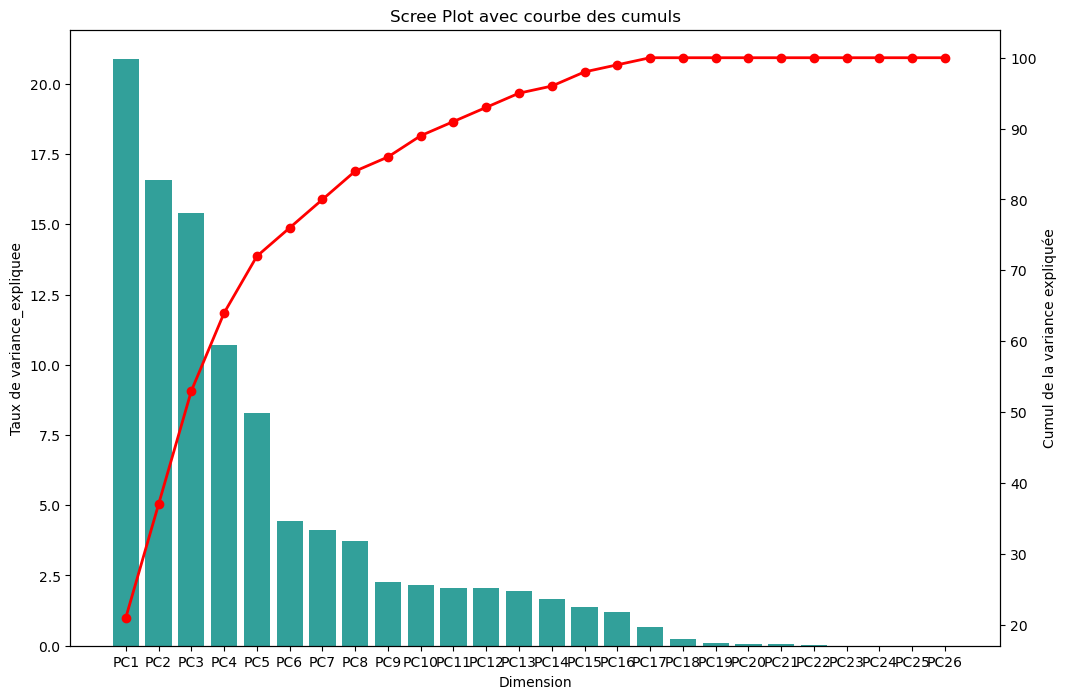

In [19]:

dim = composants.loc[:, "Dimension"]  # Récupération des noms des dimensions (PC1, PC2, etc.)
variance_rate_cum = composants.loc[:, "Taux de variance_expliquee_cum"]  
variance_rate = composants.loc[:, "Taux de variance_expliquee"] 

# Création du graphique
fig, ax = plt.subplots(figsize=(12, 8))  
sns.barplot(x=dim, y=variance_rate, palette=["lightseagreen"])  
ax.set_title('Scree Plot avec courbe des cumuls') 

# Création d'un deuxième axe y pour tracer la courbe cumulée
ax2 = ax.twinx()  # Crée un axe secondaire (ax2) avec le même axe x que ax
ax2.plot(dim, variance_rate_cum, color='red', marker='o', linestyle='-', linewidth=2)  
ax2.set_ylabel('Cumul de la variance expliquée') 

In [20]:
# Calcul du cosinus carré des variables
# Le cosinus carré représente l'importance de chaque variable dans la composante principale
cos_squared = np.square(pca.components_)  
df_cos_squared = pd.DataFrame(cos_squared, columns=['PC{}'.format(i+1) for i in range(features.shape[1])])
df_cos_squared.index = features.columns  
components = pca.components_  # Récupère les vecteurs de charge (loadings) des composantes principales
n_components = features.shape[1]  # Nombre de composantes principales, égal au nombre de variables
feature_names = features.columns  

# Calculer la contribution des variables à la formation des axes

loadings = pca.components_.T 
eigenvalues = pca.explained_variance_  # Récupère les valeurs propres associées aux composantes principales

# Calcul de la contribution des variables à chaque composante principale
variable_contributions = (loadings**2) * eigenvalues  # Chaque variable contribue à la composante en fonction de son poids et de la variance expliquée par la composante


column_names = [f'PC{i+1}_contrib' for i in range(n_components)] 
variable_contrib_df = pd.DataFrame(np.round(variable_contributions, 5), columns=column_names, index=feature_names)

# Trier les résultats par contribution à la première composante principale (PC1)
variable_contrib_df.sort_values(by='PC1_contrib', ascending=False, inplace=True)  # Trie le DataFrame en fonction de la contribution à PC1
variable_contrib_df

,PC1_contrib,PC2_contrib,PC3_contrib,PC4_contrib,PC5_contrib,PC6_contrib,PC7_contrib,PC8_contrib,PC9_contrib,PC10_contrib,...,PC17_contrib,PC18_contrib,PC19_contrib,PC20_contrib,PC21_contrib,PC22_contrib,PC23_contrib,PC24_contrib,PC25_contrib,PC26_contrib
age,0.72219,0.10403,0.01534,0.00149,0.00000,0.00065,0.00054,0.15473,0.00074,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0
duree_credit,0.70428,0.11962,0.01767,0.00086,0.00086,0.00070,0.00060,0.15526,0.00007,0.00001,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0
rev_annuel,0.14556,0.41090,0.06026,0.03067,0.32557,0.02133,0.00460,0.00081,0.00004,0.00002,...,0.00000,0.00000,0.00000,0.00000,0.00001,0.00000,0.0,0.0,0.0,0.0
duree_emploi,0.08804,0.23495,0.00019,0.61809,0.04872,0.00740,0.00254,0.00002,0.00004,0.00001,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0
montant,0.07653,0.21757,0.23629,0.18500,0.28258,0.00167,0.00030,0.00001,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00002,0.00000,0.0,0.0,0.0,0.0
propriete_MORTGAGE,0.01096,0.04270,0.00033,0.00299,0.01077,0.10991,0.04323,0.00074,0.00002,0.00110,...,0.00000,0.00000,0.00000,0.00036,0.00000,0.00000,0.0,0.0,0.0,0.0
propriete_RENT,0.01029,0.03862,0.00068,0.00452,0.00778,0.12347,0.04790,0.00076,0.00002,0.00003,...,0.00000,0.00000,0.00000,0.00036,0.00000,0.00000,0.0,0.0,0.0,0.0
intention_EDUCATION,0.00145,0.00015,0.00001,0.00005,0.00003,0.00004,0.00001,0.00118,0.14330,0.00497,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0
intention_HOMEIMPROVEMENT,0.00145,0.00003,0.00010,0.00001,0.00018,0.00008,0.00001,0.00043,0.00003,0.00004,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0
interet,0.00006,0.17108,0.74459,0.04336,0.01142,0.00002,0.00603,0.00001,0.00001,0.00000,...,0.00259,0.00109,0.00004,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0


In [21]:
 # Separation des caractéristique
X = card[["age","rev_annuel","propriete","duree_emploi",
 "intention","categorie_pret","montant", "interet","pourcentage_rev","defaut_historique","duree_credit"]]
 y = card["statut"]
print(f"Nombre de samples dans X: {len(X)}")
print(f"Nombre de samples dans y: {len(y)}")
 # Divisez les données en ensembles d'entraînement et de test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.4,random_state=42, stratify=y)
print(f"Nombre de samples dans X_train: {len(X_train)}")
print(f"Nombre de samples dans y_train: {len(y_train)}")

# Vérifiez les dimensions après la première division
print(f"Nombre de samples dans X_temp: {len(X_temp)}")
print(f"Nombre de samples dans y_temp: {len(y_temp)}")
# Divisez les données temporaires en ensembles de validation et de test

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, train_size=0.5, random_state=42, stratify=y_temp)
# Vérifiez les dimensions après la deuxième division
print(f"Nombre de samples dans X_test: {len(X_test)}")
print(f"Nombre de samples dans y_test: {len(y_test)}")
print(f"Nombre de samples dans X_val: {len(X_val)}")
print(f"Nombre de samples dans y_val: {len(y_val)}")

Nombre de samples dans X: 31686
Nombre de samples dans y: 31686
Nombre de samples dans X_train: 12674
Nombre de samples dans y_train: 12674
Nombre de samples dans X_temp: 19012
Nombre de samples dans y_temp: 19012
Nombre de samples dans X_test: 9506
Nombre de samples dans y_test: 9506
Nombre de samples dans X_val: 9506
Nombre de samples dans y_val: 9506


# 4. Modelisation des données

> **REGRESSION LOGISTIQUE**

Pipeline du modèle d'arbre de décision
Le pipeline permet de gérer toutes les étapes du prétraitement et de la modélisation dans une séquence cohérente.
Prétraitement : transformation des colonnes numériques et catégoriques

**Un pipeline garantit que chaque étape est appliquée de manière cohérente. Lorsque vous sauvegardez ou déployez un modèle, vous pouvez l'utiliser sur de nouvelles données en vous assurant que les mêmes transformations sont appliquées avant d'effectuer les prédictions.**

In [22]:


# Prétraitement : transformation des colonnes numériques et catégoriques
cat_norm = ["propriete","intention","categorie_pret", "defaut_historique"]
num_norm = ["age","rev_annuel","duree_emploi","montant", "interet","duree_credit"]

# numériques et catégorielles
prepros = ColumnTransformer(
    transformers=[
        # Application de OneHotEncoder sur les variables catégorielles, pour les transformer en variables binaires
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_norm), # Gestion des inconnus dans les catégories
        # Application de StandardScaler pour normaliser les variables numériques
        ("num", StandardScaler(), num_norm)
    ]
)

# Création d'un pipeline avec plusieurs étapes
pipe_log = Pipeline([
    ("preprocessing", prepros),  # Étape de prétraitement
    ("pca", PCA(n_components=4)),  # Réduction de la dimensionnalité avec PCA (4 composantes principales)
    ("over", SMOTE(random_state=1)),  # Augmentation des données minoritaires avec SMOTE (Suréchantillonnage)
    ("under", RandomUnderSampler(random_state=1)),  # Sous-échantillonnage des données majoritaires avec RandomUnderSampler
    ("tree", LogisticRegression(solver='liblinear'))  # Modèle de régression logistique
])


try:
    
    pipe_log
    print("Modèle chargé avec succès.") 
except ValueError as ve:
    print(f"Erreur de valeur : {ve}")  # Gestion des erreurs de valeur
except NotFittedError as nfe:
    print(f"Erreur d'ajustement : {nfe}")  # Gestion des erreurs d'ajustement (modèle non entraîné)
except Exception as e:
    print(f"Erreur générale : {e}")  # Gestion d'autres erreurs générales


Modèle chargé avec succès.


SMOTE signifie Synthetic Minority Over-sampling Technique.
C’est une technique d’over-sampling utilisée pour équilibrer un jeu de données déséquilibré, c’est-à-dire quand une classe (souvent la classe positive, par exemple "client en défaut") est beaucoup moins représentée que l'autre.

Problème typique :
Imaginons que ton jeu de données contient :
90% de clients non en défaut (classe 0)
10% de clients en défaut (classe 1)

Un modèle pourrait être tenté de tout prédire comme classe 0 pour avoir une "bonne" précision, mais il serait inutile pour détecter les défauts.

SMOTE crée de nouveaux exemples synthétiques (fictifs mais réalistes) de la classe minoritaire en se basant sur ses voisins proches.

In [23]:
 # Entrainnement du modele
pipe_log.fit(X_train, y_train)
# Prediction du modele
y_pred0 = pipe_log.predict(X_test)
y_pred0_proba = pipe_log.predict_proba(X_test)[:,1]
print(y_pred0_proba,"\n", y_pred0)

[0.26733994 0.81750057 0.35131381 ... 0.24868199 0.49950752 0.13596675] 
 [0 1 0 ... 0 0 0]


In [24]:
nouvel_individu = pd.DataFrame({
    "propriete": ["locataire"],
    "intention": ["personnel"],
    "categorie_pret": ["voiture"],
    "defaut_historique": ["non"],
    "age": [35],
    "rev_annuel": [50000],
    "duree_emploi": [5],
    "montant": [15000],
    "interet": [7.5],
    "duree_credit": [36]
})
nouvel_individu

,propriete,intention,categorie_pret,defaut_historique,age,rev_annuel,duree_emploi,montant,interet,duree_credit
0,locataire,personnel,voiture,non,35,50000,5,15000,7.5,36


In [25]:
y_nouvelle_pred = pipe_log.predict(nouvel_individu)
y_nouvelle_proba = pipe_log.predict_proba(nouvel_individu)
print(y_nouvelle_pred  ,y_nouvelle_proba)

[0] [[0.80299646 0.19700354]]


In [26]:
# Fonction d'évaluation de la performance du modèle
def model_performance(data_test, data_pred, data_pred_prob):
    # Calcul de la matrice de confusion normalisée (%)
    # La matrice de confusion montre la répartition des vrais positifs, faux positifs, vrais négatifs et faux négatifs
    cm = (confusion_matrix(data_test, data_pred) / len(data_test)) * 100
    tn, fp, fn, tp = cm.ravel()  # Extraction des 4 valeurs : vrais négatifs (tn), faux positifs (fp), faux négatifs (fn), vrais positifs (tp)
    
   
    print(classification_report(data_test, data_pred))  
    
    # Affichage des valeurs de la matrice de confusion
    print("True Negatif :", np.round(tn, 3))  
    print("False Positif :", np.round(fp, 3))  
    print("False Negatif :", np.round(fn, 3)) 
    print("True Positif :", np.round(tp, 3))  
    
    # Calcul des taux de faux positifs (FPR) et de vrais positifs (TPR) pour la courbe ROC
    fpr, tpr, _ = roc_curve(data_test, data_pred_prob)  # fpr = taux de faux positifs, tpr = taux de vrais positifs
    
    # Affichage de la matrice de confusion sous forme de heatmap (carte de chaleur)
    print("Matrice de Confusion")
    fig, ax = plt.subplots(figsize=(10, 6))  
    sns.heatmap(np.round(cm, 6), annot=True, cmap='Blues') 
    plt.title('Matrice de Confusion') 
    plt.xlabel('Classe Prédite')  
    plt.ylabel('Classe Réelle') 
    plt.show()  
    
    # Calcul de l'AUC (Area Under the Curve) de la courbe ROC, qui représente la capacité du modèle à différencier les classes
    roc_auc = roc_auc_score(data_test, data_pred_prob)
    
    # Tracer la courbe ROC
    plt.figure(figsize=(10, 6)) 
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})') 
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Tracé de la diagonale représentant un modèle aléatoire
    plt.xlim([0.0, 1.0])  
    plt.ylim([0.0, 1.05])  
    plt.xlabel('Taux de Faux Positifs (FPR)')  
    plt.ylabel('Taux de Vrais Positifs (TPR)')  
    plt.title('Courbe ROC') 
    plt.legend(loc="lower right")  
    plt.show()  # Affichage de la courbe ROC


 >4.3 **Validation croisée**

In [27]:
# Appliquer la validation croisée avec comme métrique AUC (aire sous la courbe ROC)
k_fold = KFold(n_splits=5, shuffle=True, random_state=1)
score_cv = cross_val_score(
    pipe_log,       
    X_train,        
    y_train,        
    cv=k_fold,    
    scoring='roc_auc',  # La métrique utilisée : AUC ROC
    n_jobs=-1       # Utiliser tous les cœurs du processeur pour accélérer le calcul
).mean()           # On prend la moyenne des 5 scores AUC obtenus
print("AUC avec le Cross validation : ", np.round(score_cv,2))


AUC avec le Cross validation :  0.75


**Pourquoi on a besoin de la fonction get_valid_ratios() plus haut ?**
Parce que tu ne peux pas mettre n’importe quel ratio de suréchantillonnage ou sous-échantillonnage. Il faut qu’il soit cohérent avec la taille réelle de tes données.

**Exemple :**
on a :

900 instances de classe 0 (majoritaire)

100 instances de classe 1 (minoritaire)

Alors :

Le maximum qu'on puisse faire avec SMOTE c’est de créer 800 nouvelles instances de la classe minoritaire, pour arriver à 900 → ratio 800/100 = 8 (i.e., sampling_strategy = 0.8)

Et à l’inverse, tu ne peux pas faire de l’under-sampling à un ratio supérieur à 100/900 ≈ 0.11


Donc, la fonction **get_valid_ratios()** t’aide à :  **vérifier à l’avance les valeurs possibles de sampling_strategy pour SMOTE (over) et RandomUnderSampler (under),**

éviter les erreurs comme "not enough samples" pendant l’entraînement.

              precision    recall  f1-score   support

           0       0.89      0.66      0.76      7458
           1       0.36      0.70      0.48      2048

    accuracy                           0.67      9506
   macro avg       0.63      0.68      0.62      9506
weighted avg       0.78      0.67      0.70      9506

True Negatif : 52.135
False Positif : 26.32
False Negatif : 6.47
True Positif : 15.075
Matrice de Confusion


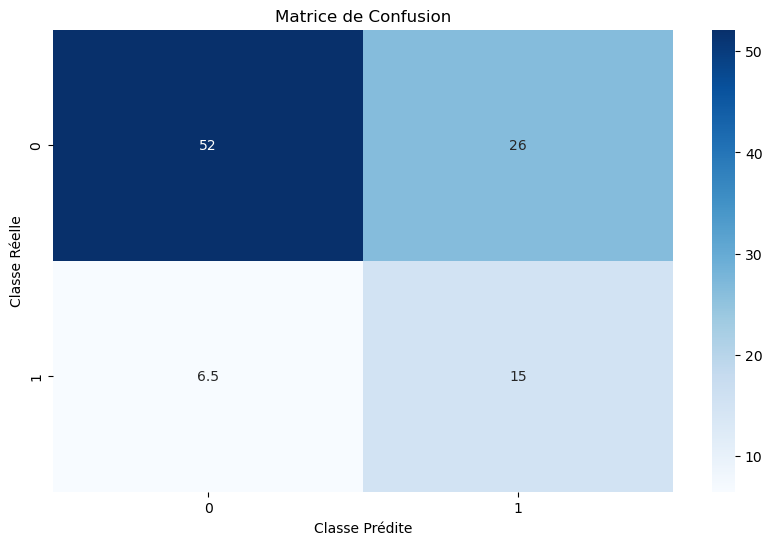

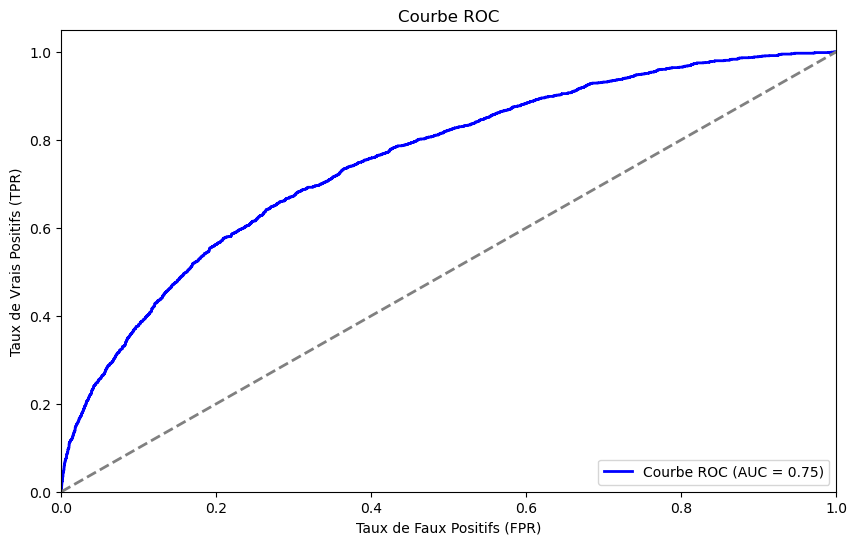

In [28]:
model_performance(y_test, y_pred0, y_pred0_proba)

 **L’AUC (Area Under the Curve) est une mesure de performance pour les modèles de classification binaire. Elle représente la capacité du modèle à distinguer entre les classes positives (1) et négatives (0).**

**Une AUC = 0.5 → le modèle est aussi bon que le hasard (aucune capacité à différencier).**


Une AUC = 1.0 → modèle parfait (il classe toutes les observations correctement).


Une AUC = 0.75 → le modèle est bon, il a 75 % de chances de prédire correctement qu’un individu pris au hasard dans la classe positive sera classé avec une probabilité plus haute qu’un individu pris dans la classe négative.

In [29]:
# Fonction pour calculer dynamiquement les ratios réalisables d'over-sampling et d'under-sampling
def get_valid_ratios(X, y):
    # Calcul de la distribution des classes dans y (ex: 0 = rejeté, 1 = approuvé)
    class_counts = Counter(y)  # Compte le nombre d'éléments de chaque classe
    
    # Identification de la classe majoritaire et minoritaire
    major_class = max(class_counts, key=class_counts.get)  # Classe la plus représentée
    minor_class = min(class_counts, key=class_counts.get)  # Classe la moins représentée
    n_major = class_counts[major_class]  # Nombre d'observations dans la classe majoritaire
    n_minor = class_counts[minor_class]  # Nombre d'observations dans la classe minoritaire

    # Calcul des ratios maximaux possibles
    max_over_ratio = n_major / n_minor - 1  # Ratio maximal de suréchantillonnage
    max_under_ratio = n_minor / n_major     # Ratio maximal de sous-échantillonnage

    # Définition des ratios "pratiques" (par pas de 0.1) qu'on peut effectivement utiliser
    over_ratios = [r for r in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] if r <= max_over_ratio]
    under_ratios = [r for r in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] if r <= max_under_ratio]

    # La fonction retourne deux listes de ratios exploitables pour équilibrer les classes
    return over_ratios, under_ratios

over_ratios, under_ratios = get_valid_ratios(X_train, y_train)
print(over_ratios,under_ratios)


[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] [0.1, 0.2]


**over_ratios (suréchantillonnage)**

Ça veut dire que tu peux augmenter la classe minoritaire jusqu’à 0.9 fois la taille de la classe majoritaire sans dépasser les limites logiques.

Exemple : si tu choisis un over_ratio = 0.5, SMOTE va générer 50% de données en plus pour la classe minoritaire.

**under_ratios (sous-échantillonnage)**

Ça veut dire que tu peux réduire la classe majoritaire jusqu’à 0.2 fois la taille de la classe minoritaire.

**Pourquoi on a besoin de la fonction get_valid_ratios() plus haut ?**

Parce qu'on ne peut pas mettre n’importe quel ratio de suréchantillonnage ou sous-échantillonnage. Il faut qu’il soit cohérent avec la taille réelle de tes données.

**Exemple :**
on a :

900 instances de classe 0 (majoritaire)

100 instances de classe 1 (minoritaire)

Alors :

Le maximum qu'on puisse faire avec SMOTE c’est de créer 800 nouvelles instances de la classe minoritaire, pour arriver à 900 → ratio 800/100 = 8 (i.e., sampling_strategy = 0.8)

Et à l’inverse, tu ne peux pas faire de l’under-sampling à un ratio supérieur à 100/900 ≈ 0.11


Donc, la fonction **get_valid_ratios()** t’aide à :  **vérifier à l’avance les valeurs possibles de sampling_strategy pour SMOTE (over) et RandomUnderSampler (under),**

éviter les erreurs comme "not enough samples" pendant l’entraînement.

> 4.4 **Optimisation des hyperparamètres**

In [30]:
# Sélection des variables explicatives (X) et de la variable cible (y)
X = card[["age", "rev_annuel", "propriete", "duree_emploi", 
          "intention", "categorie_pret", "montant", "interet", 
          "pourcentage_rev", "defaut_historique", "duree_credit"]]
y = card["statut"]

# Division du jeu de données en trois parties :
# - 40% pour l'entraînement (X_train, y_train)
# - 30% pour le test (X_test, y_test)
# - 30% pour la validation (X_val, y_val) Valider et choisir les meilleurs hyperparamètres (ex: n_neighbors, C, max_depth, etc.)
# On utilise la stratification pour garder les proportions des classes
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.4, 
                                                    random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, train_size=0.5,
                                                random_state=42, stratify=y_temp)

#  Mise en place de la validation croisée avec 5 plis (KFold)
k_fold = KFold(n_splits=5, shuffle=True, random_state=1)

#  Définir les colonnes à traiter
cat_norm = ["propriete", "intention", "categorie_pret", "defaut_historique"]  # colonnes catégorielles
num_norm = ["age", "rev_annuel", "duree_emploi", "montant", "interet", "duree_credit"]  # colonnes numériques

# Prétraitement des données
prepros = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_norm),  # Encodage des variables catégorielles
        ("num", StandardScaler(), num_norm)  # Normalisation des variables numériques
    ]
)

# Construction d’un pipeline complet
pipe_log = Pipeline([
    ("preprocessing", prepros),                 # Étape 1 : transformation
    ("pca", PCA(n_components=5)),               # Étape 2 : réduction de dimensionnalité
    ("under", RandomUnderSampler(random_state=1)),  # Étape 3 : sous-échantillonnage de la classe majoritaire
    ("tree", LogisticRegression(solver='liblinear'))  # Étape 4 : modèle de régression logistique
])

# Définition d'une grille de recherche d'hyperparamètres pour GridSearchCV
param_grid = {
    'under__sampling_strategy': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],  # différents niveaux de sous-échantillonnage
    'tree__solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga']  # solveurs compatibles pour la régression logistique
}

# Création d’un GridSearchCV pour optimiser les hyperparamètres du pipeline
log_grid = GridSearchCV(
    pipe_log,                # pipeline complet
    param_grid,              # grille de paramètres
    scoring='roc_auc',       # on évalue les modèles avec la métrique AUC
    cv=k_fold,               # on utilise une validation croisée à 5 plis
    n_jobs=-1,               # exécuter en parallèle avec tous les cœurs disponibles
    error_score='raise'      # lever une erreur si quelque chose échoue
)

# Entraînement du modèle avec gestion des erreurs
try:
    log_grid.fit(X_train, y_train)  # entraînement du pipeline avec recherche de meilleurs paramètres
    print("Modèle ajusté avec succès.")
except ValueError as ve:
    print(f"Erreur de valeur : {ve}")
except NotFittedError as nfe:
    print(f"Erreur d'ajustement : {nfe}")
except Exception as e:
    print(f"Erreur générale : {e}")


Modèle ajusté avec succès.


si on fait du GridSearchCV ou du RandomSearch (recherche d’hyperparamètres),
et qu'on  utilises X_test pour optimiser les performances, on triche sans le savoir :
on est en train d'ajuster notre  modèle à nos test, donc ce n’est plus un vrai test .
Le test est censé représenter le monde réel — des données jamais vues, jamais utilisées.

Quand faut-il une 3ᵉ partie validation ?
Quand on veut faire de l’optimisation d’hyperparamètres manuellement.

Quand on veut sélectionner entre plusieurs modèles (Random Forest vs XGBoost vs LogisticRegression...).

Quand on ne veut pas inclure le test dans les décisions avant l'évaluation finale.

Alternative : Cross-validation

On peut parfois éviter d’avoir un X_val séparé si tu fais de la validation croisée (avec GridSearchCV).

Mais dans ce cas, ton test (X_test) ne doit jamais être utilisé pendant la cross-validation.



In [31]:
print(log_grid.best_params_)
print(log_grid.best_estimator_)

{'tree__solver': 'liblinear', 'under__sampling_strategy': 0.5}
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['propriete', 'intention',
                                                   'categorie_pret',
                                                   'defaut_historique']),
                                                 ('num', StandardScaler(),
                                                  ['age', 'rev_annuel',
                                                   'duree_emploi', 'montant',
                                                   'interet',
                                                   'duree_credit'])])),
                ('pca', PCA(n_components=5)),
                ('under',
                 RandomUnderSampler(random_state=1, sampling_strategy=0.5)),
                ('tree', Log

# 4.4 Évaluation finale du modèle logistique

In [51]:
 # Entrainnement
log_grid.fit(X_train,y_train)
 # Prediction
pred_val = log_grid.predict(X_val)
pred_prob = log_grid.predict_proba(X_val)[:,1]

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      7458
           1       0.54      0.55      0.55      2048

    accuracy                           0.80      9506
   macro avg       0.71      0.71      0.71      9506
weighted avg       0.80      0.80      0.80      9506

True Negatif : 68.146
False Positif : 10.309
False Negatif : 9.594
True Positif : 11.95
Matrice de Confusion


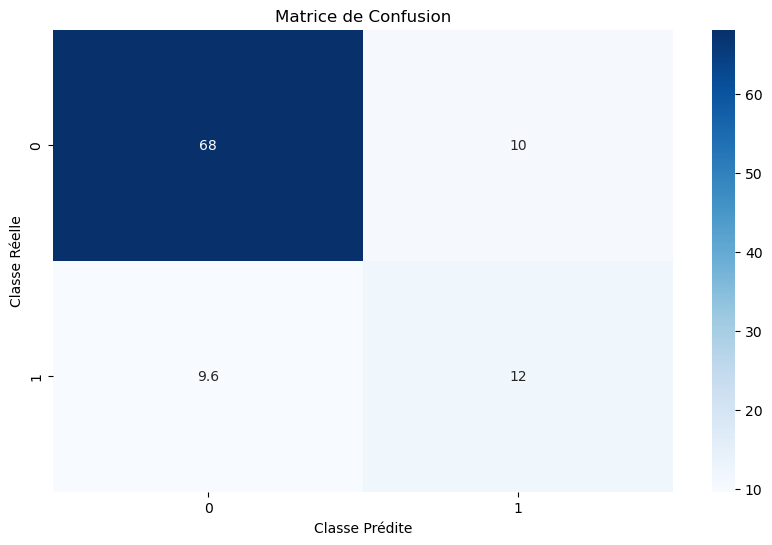

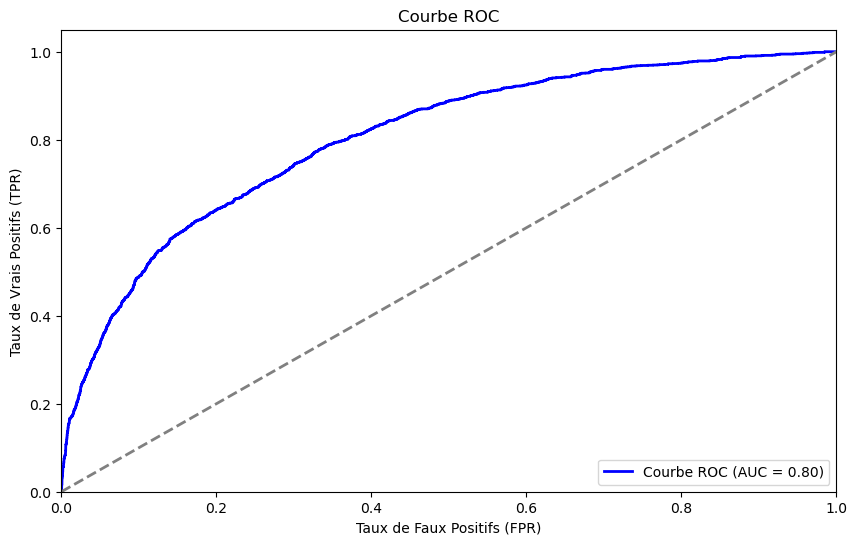

In [52]:
 model_performance(y_val, pred_val, pred_prob)

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      7458
           1       0.53      0.55      0.54      2048

    accuracy                           0.80      9506
   macro avg       0.70      0.71      0.71      9506
weighted avg       0.80      0.80      0.80      9506

True Negatif : 67.989
False Positif : 10.467
False Negatif : 9.71
True Positif : 11.835
Matrice de Confusion


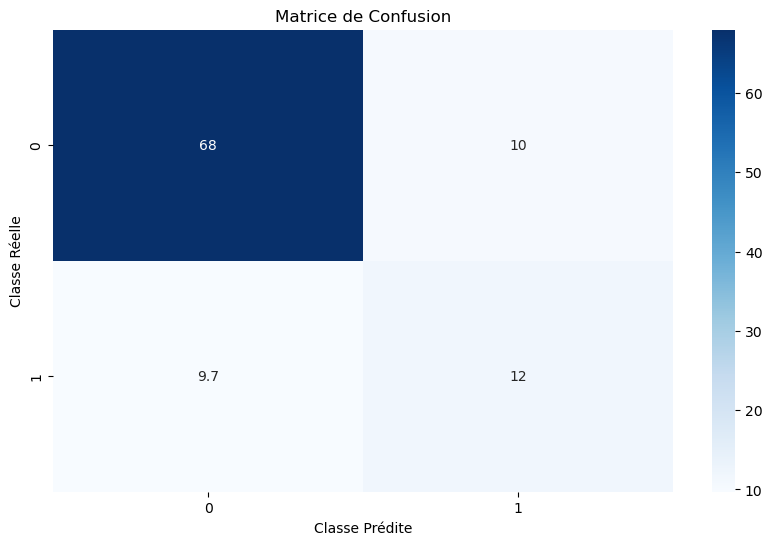

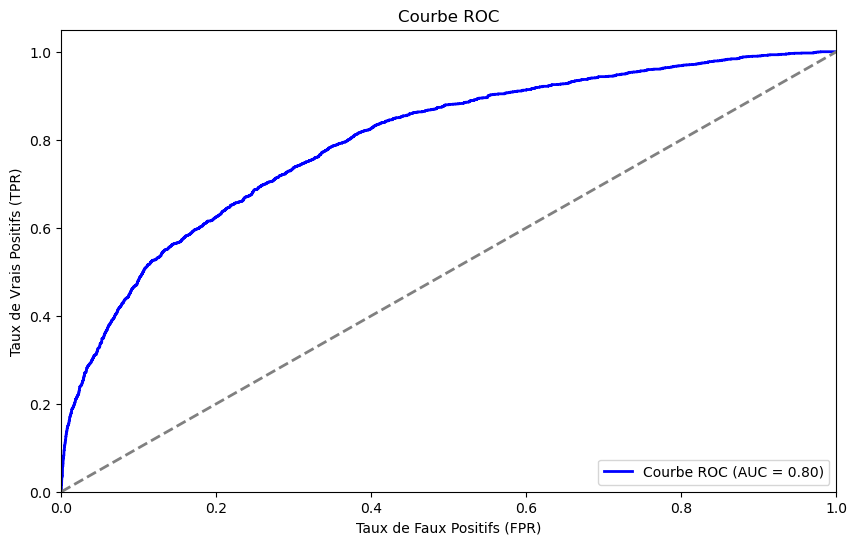

In [61]:
# Une fois l'ajustement terminé, utiliser le meilleur modèle trouvé avec GridSearchCV pour faire des prédictions sur le test
best_model_log = log_grid.best_estimator_  # Récupère le meilleur modèle ajusté

# Prédictions sur le jeu de test
y_pred_log = best_model_log.predict(X_test)               # Prédictions de la classe
y_pred_log_proba = best_model_log.predict_proba(X_test)[:, 1]  # Probabilités associées à la classe positive

# Évaluer les performances sur le jeu de test
model_performance(y_test, y_pred_log, y_pred_log_proba)  # Utiliser y_test pour comparer les prédictions du modèle


# 2. MODÈLE D’ARBRE DE DÉCISION

In [34]:
# Ce pipeline prépare les données et entraîne un modèle d'arbre de décision (DecisionTreeClassifier).

# Définition des colonnes à transformer
cat_prepos = ["propriete", "intention", "categorie_pret", "defaut_historique"]  # colonnes catégorielles
num_prepos = ["age", "rev_annuel", "duree_emploi", "montant", "interet", "duree_credit"]  # colonnes numériques (non utilisées ici mais potentiellement utiles plus tard)

# On utilise ColumnTransformer pour appliquer un encodage one-hot aux variables catégorielles.
# Cela permet de transformer les variables non numériques en une représentation binaire compréhensible par les modèles.
# 'handle_unknown="ignore"' est important pour éviter les erreurs si des catégories inconnues apparaissent lors du test.
prepros = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_prepos)
    ]
)

# Étape 3 : Création du pipeline
pipe_tree = Pipeline([
    ("preprocessing", prepros),  # Application de l'encodage one-hot sur les variables catégorielles
    ("under", RandomUnderSampler(random_state=1)),  # Sous-échantillonnage pour rééquilibrer les classes (réduit la majorité)
    ("tree", DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=2))  # Modèle d'arbre de décision :
                                                                                      # - 'gini' pour mesurer l'impureté,
                                                                                      # - 'best' pour choisir la meilleure séparation,
                                                                                      # - profondeur maximale fixée à 2 (évite le surapprentissage)
])


In [35]:
 # Entrainement du modèle
pipe_tree.fit(X_train, y_train)
 # Prediction
y_pred_val = pipe_tree.predict(X_test)
y_pred_prob = pipe_tree.predict_proba(X_test)[:,1]

              precision    recall  f1-score   support

           0       0.91      0.52      0.66      7458
           1       0.32      0.81      0.46      2048

    accuracy                           0.58      9506
   macro avg       0.61      0.66      0.56      9506
weighted avg       0.78      0.58      0.62      9506

True Negatif : 40.9
False Positif : 37.555
False Negatif : 4.124
True Positif : 17.421
Matrice de Confusion


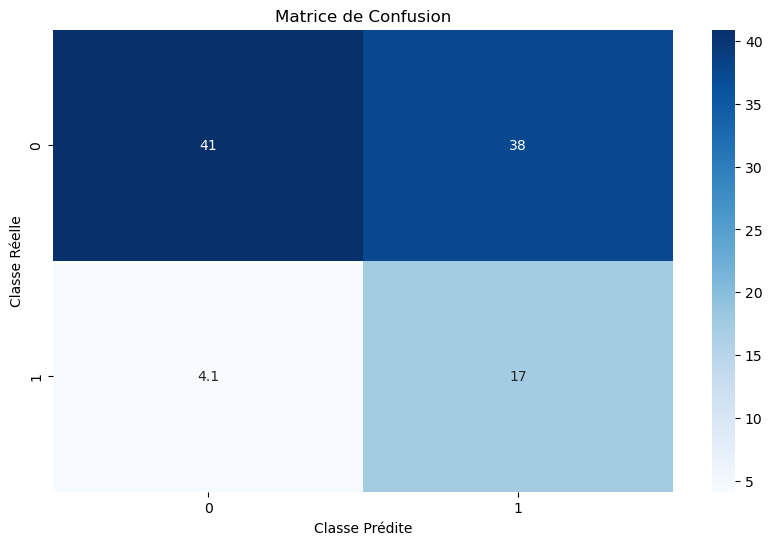

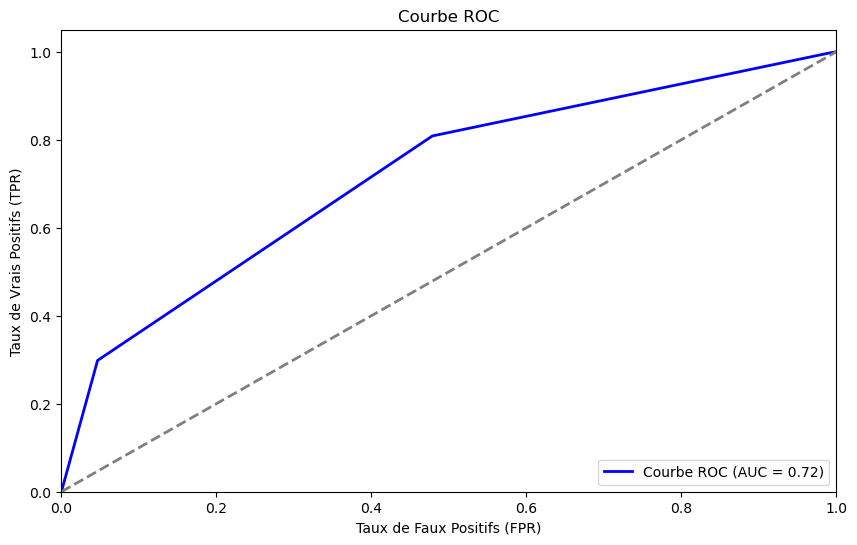

In [36]:
 # Metrics de performance
model_performance(y_test,y_pred_val,y_pred_prob)

> Optimisation avec les Hyperparamètres

In [58]:
# Ce bloc effectue une recherche d'hyperparamètres pour un arbre de décision via un pipeline
# Il inclut un sous-échantillonnage pour équilibrer les classes et optimise la performance selon l'AUC

# Définition d’un grid réduit de paramètres à tester pour accélérer la recherche
para_grid = {
    'under__sampling_strategy': [0.6, 0.8, 1],          # Niveaux de sous-échantillonnage des classes majoritaires
    'tree__max_features': ['sqrt', None],               # Méthodes de sélection de variables pour les splits
    'tree__criterion': ['gini', 'entropy'],             # Métriques de qualité pour les splits
    'tree__max_depth': [3, 6, 9],                       # Profondeur maximale de l’arbre (pour contrôler le surapprentissage)
    'tree__min_samples_split': [2, 4]                   # Nombre minimum d’échantillons pour diviser un noeud
}

# Initialisation de GridSearchCV avec validation croisée (kfold)
tree_grid = GridSearchCV(
    estimator=pipe_tree,           # Pipeline contenant preprocessing, undersampling et arbre
    param_grid=para_grid,          # Grille des hyperparamètres à tester
    scoring='roc_auc',             # Métrique d'évaluation : AUC (Area Under the Curve)
    n_jobs=-1,                     # Utilise tous les cœurs CPU disponibles
    cv=k_fold                       # Validation croisée (déjà définie auparavant)
)

# Ajustement du modèle avec gestion des erreurs en cas d’échec
try:
    tree_grid.fit(X_train, y_train)
    print("Modèle est bien ajusté")
except Exception as e:
    print(f"Erreur lors de l'ajustement du modèle : {e}")
print("Meilleur score AUC :", tree_grid.best_score_)

Modèle est bien ajusté
Meilleur score AUC : 0.8016759865659502


In [46]:
print(tree_grid.best_params_)
print(tree_grid.best_estimator_)

{'tree__criterion': 'entropy', 'tree__max_depth': 9, 'tree__max_features': None, 'tree__min_samples_split': 4, 'under__sampling_strategy': 0.6}
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['propriete', 'intention',
                                                   'categorie_pret',
                                                   'defaut_historique'])])),
                ('under',
                 RandomUnderSampler(random_state=1, sampling_strategy=0.6)),
                ('tree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=9,
                                        min_samples_split=4))])


In [49]:
 # Entrainnement
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['propriete',
                                                                          'intention',
                                                                          'categorie_pret',
                                                                          'defaut_historique'])])),
                                       ('under',
                                        RandomUnderSampler(random_state=1)),
                                       ('tree',
                                        DecisionTreeClassifier(max_depth=2))]),
             n_jobs=-1,
             param_grid={'tree__criterion': ['gini', 'entropy'],
                         'tree__max_depth': [3, 6, 9],
                         'tree__max_features': ['sqrt', None],
                         'tree__min_samples_split': [2, 4],
                         'under__sampling_strategy': [0.6, 0.8, 1]},
             scoring='roc_auc')

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      7458
           1       0.68      0.43      0.53      2048

    accuracy                           0.83      9506
   macro avg       0.77      0.69      0.71      9506
weighted avg       0.82      0.83      0.82      9506

True Negatif : 74.006
False Positif : 4.45
False Negatif : 12.192
True Positif : 9.352
Matrice de Confusion


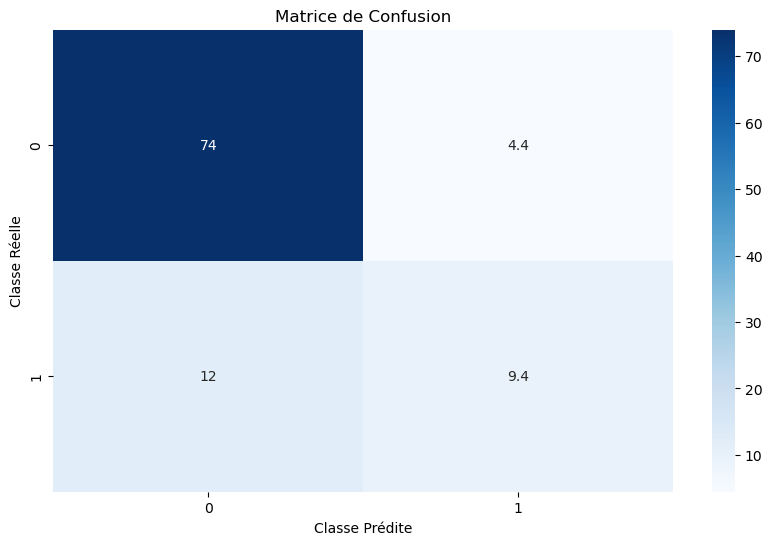

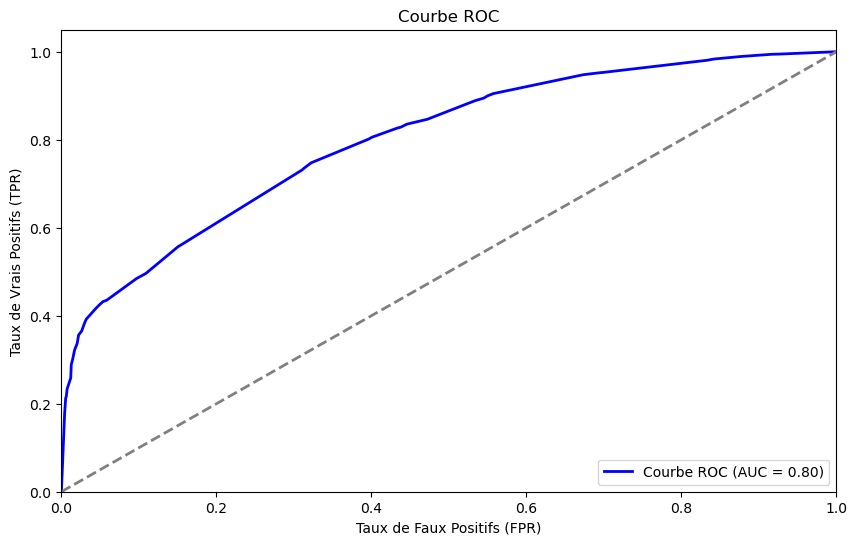

In [57]:
predval = tree_grid.predict(X_val)
preprob = tree_grid.predict_proba(X_val)[:,1]
model_performance(y_val, predval,preprob)

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      7458
           1       0.69      0.43      0.53      2048

    accuracy                           0.83      9506
   macro avg       0.77      0.69      0.71      9506
weighted avg       0.82      0.83      0.82      9506

True Negatif : 74.248
False Positif : 4.208
False Negatif : 12.34
True Positif : 9.205
Matrice de Confusion


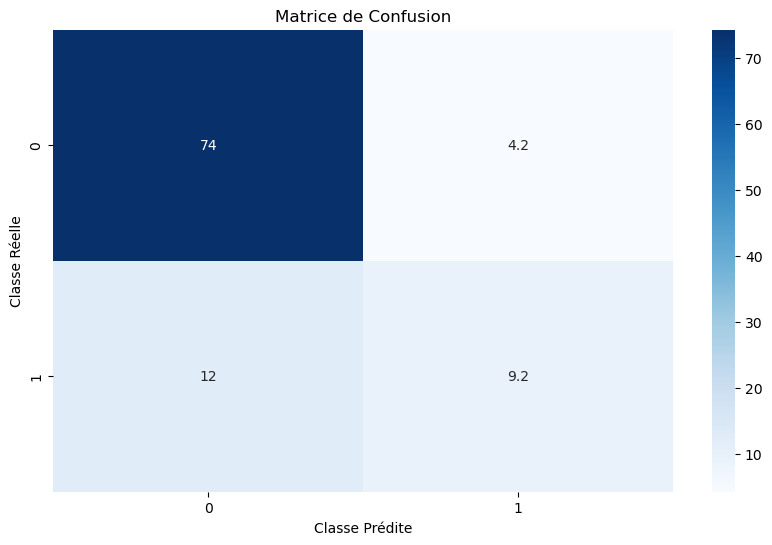

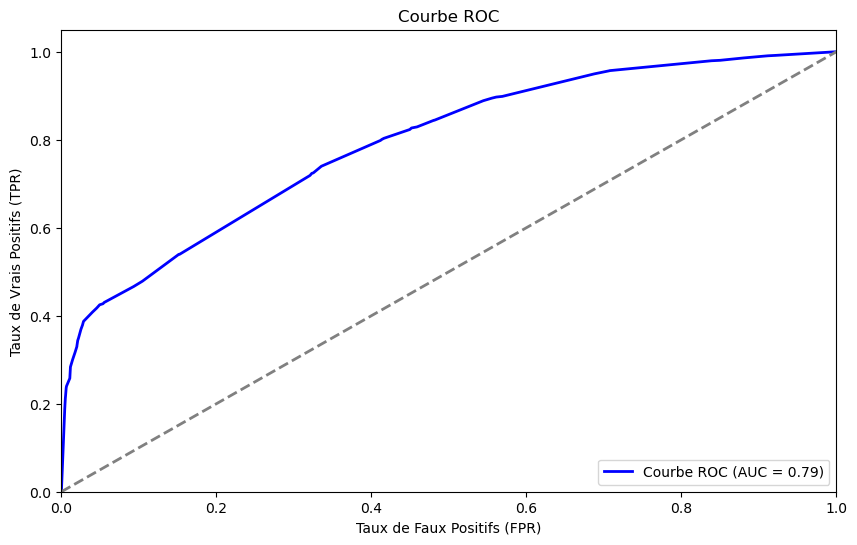

In [62]:
# Une fois l'ajustement terminé, utiliser le meilleur modèle trouvé avec GridSearchCV pour faire des prédictions sur le test
best_model_tree = tree_grid.best_estimator_  # Récupère le meilleur modèle ajusté

# Prédictions sur le jeu de test
y_pred_tree = best_model.predict(X_test)               # Prédictions de la classe
y_pred_tree_proba = best_model_tree.predict_proba(X_test)[:, 1]  # Probabilités associées à la classe positive

# Évaluer les performances sur le jeu de test
model_performance(y_test, y_pred_tree, y_pred_tree_proba)  # Utiliser y_test pour comparer les prédictions du modèle


>4.6 Optimisation des Hyperparamètres


# 5 MODELE RANDOMFOREEST

              precision    recall  f1-score   support

           0       0.88      0.78      0.83      7458
           1       0.44      0.61      0.51      2048

    accuracy                           0.75      9506
   macro avg       0.66      0.70      0.67      9506
weighted avg       0.78      0.75      0.76      9506

True Negatif : 61.424
False Positif : 17.031
False Negatif : 8.363
True Positif : 13.181
Matrice de Confusion


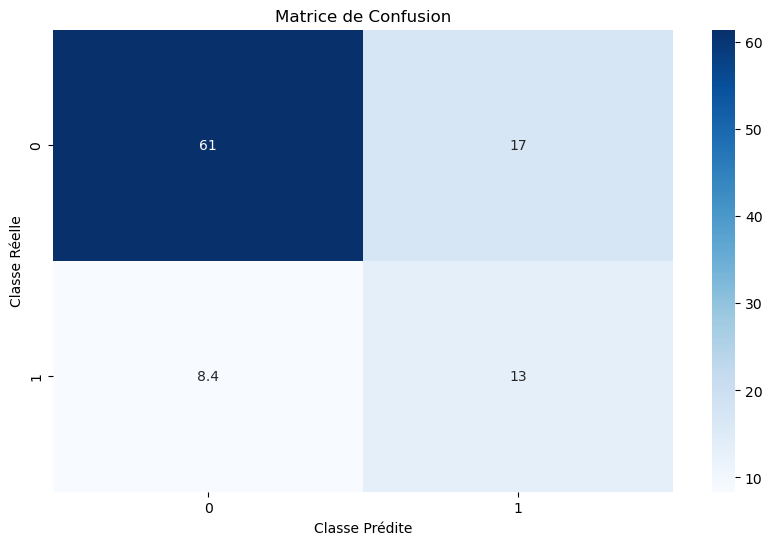

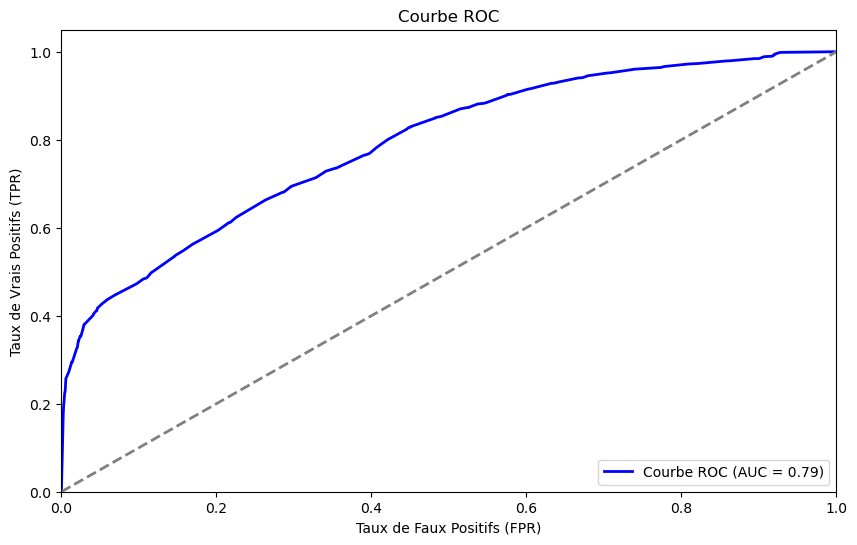

In [38]:
# Pipeline pour le modèle Random Forest
pipe_rf = Pipeline([
 ("preprocessing", prepros),
 ("under", RandomUnderSampler(random_state=1)),
 ("rf", RandomForestClassifier(random_state=1))
 ])
 # Entraînement du modèle
pipe_rf.fit(X_train, y_train)
 # Prédictions
y_pred_rf = pipe_rf.predict(X_test)
y_pred_rf_proba = pipe_rf.predict_proba(X_test)[:, 1]
 # Évaluation des performances
model_performance(y_test, y_pred_rf, y_pred_rf_proba)

>**Optimisation des Hyperparamètres**

In [40]:
# Définir les paramètres pour GridSearchCV
param_grid_rf = {
    'under__sampling_strategy': [0.8],
    'rf__n_estimators': [100],          # Nombre d'arbres dans la forêt
    'rf__max_depth': [10, 20],          # Profondeur maximale des arbres
    'rf__min_samples_split': [2, 5],    # Min. d'échantillons pour diviser un nœud
    'rf__min_samples_leaf': [1, 2],     # Min. d'échantillons dans une feuille
    'rf__criterion': ['gini']           # Critère de qualité du split
}
# Initialiser GridSearchCV
rf_grid = GridSearchCV(
    pipe_rf,                    # Pipeline complet : préprocessing + sous-échantillonnage + modèle RF
    param_grid_rf,              # Grille des hyperparamètres
    scoring='roc_auc',          # Utiliser l'AUC comme métrique de performance
    n_jobs=-1,                  # Utiliser tous les cœurs disponibles pour paralléliser
    cv=k_fold                   # Validation croisée avec KFold (5 plis dans ton cas)
)

# Ajustement du modèle avec gestion des erreurs
try:
    rf_grid.fit(X_train, y_train)
    print("Modèle ajusté avec succès.")
except Exception as e:
    print(f"Erreur lors de l'ajustement du modèle : {e}")

# Affichage des meilleurs hyperparamètres trouvés et du score AUC correspondant
print("Meilleurs paramètres :", rf_grid.best_params_)
print("Meilleur score AUC :", rf_grid.best_score_)


Modèle ajusté avec succès.
Meilleurs paramètres : {'rf__criterion': 'gini', 'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 100, 'under__sampling_strategy': 0.8}
Meilleur score AUC : 0.8051518460607472


              precision    recall  f1-score   support

           0       0.88      0.85      0.86      7458
           1       0.50      0.56      0.53      2048

    accuracy                           0.79      9506
   macro avg       0.69      0.70      0.70      9506
weighted avg       0.79      0.79      0.79      9506

True Negatif : 66.442
False Positif : 12.013
False Negatif : 9.457
True Positif : 12.087
Matrice de Confusion


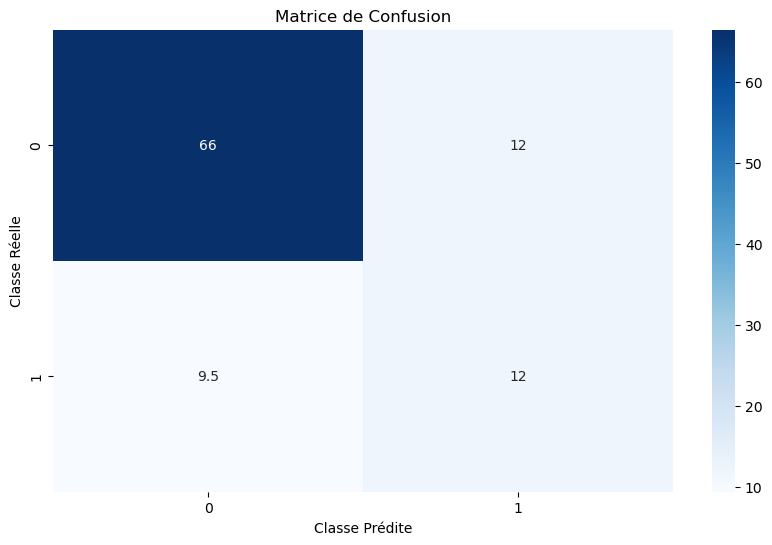

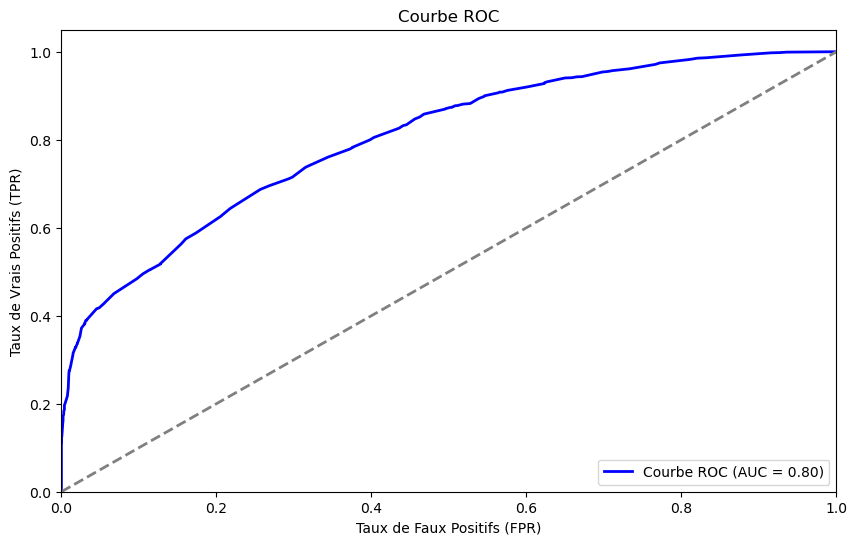

In [64]:
predval = rf_grid.predict(X_val)
preprob = rf_grid.predict_proba(X_val)[:,1]
model_performance(y_val, predval,preprob)

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      7458
           1       0.49      0.54      0.51      2048

    accuracy                           0.78      9506
   macro avg       0.68      0.69      0.69      9506
weighted avg       0.79      0.78      0.78      9506

True Negatif : 66.474
False Positif : 11.982
False Negatif : 9.994
True Positif : 11.551
Matrice de Confusion


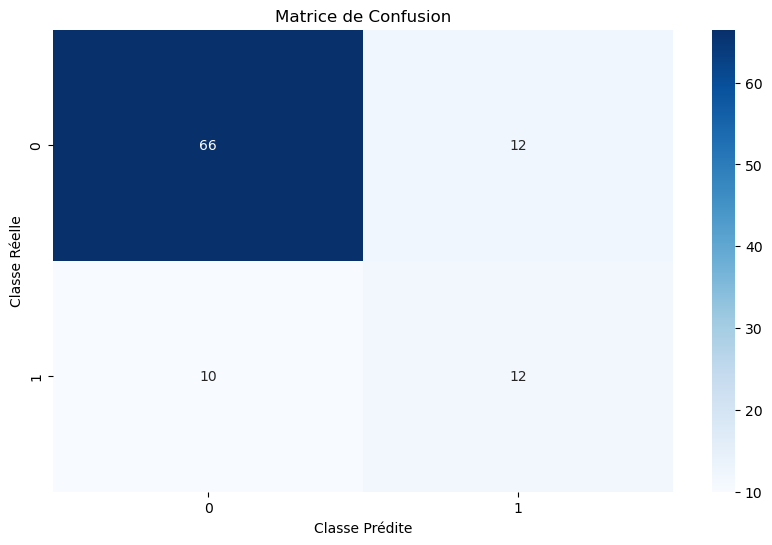

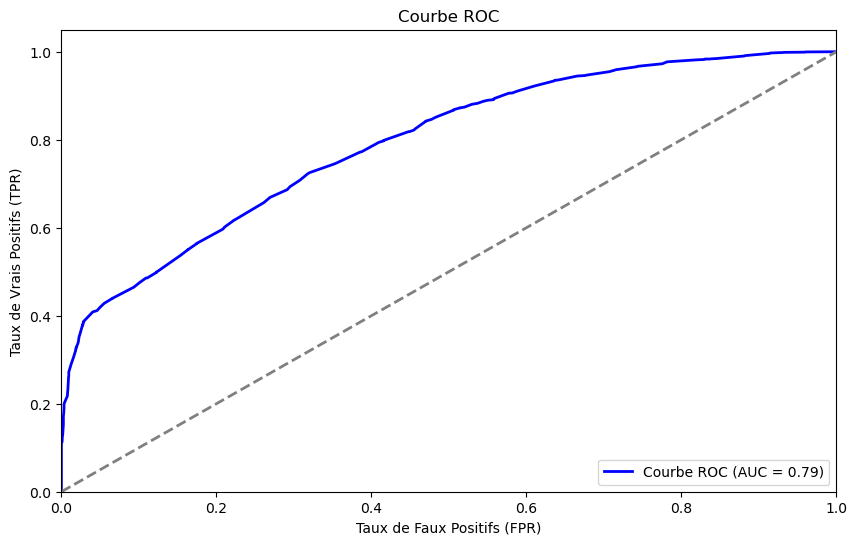

In [65]:
# Une fois l'ajustement terminé, utiliser le meilleur modèle trouvé avec GridSearchCV pour faire des prédictions sur le test
best_model_rf = rf_grid.best_estimator_  # Récupère le meilleur modèle ajusté

# Prédictions sur le jeu de test
y_pred_rf = best_model_rf.predict(X_test)               # Prédictions de la classe
y_pred_rf_proba = best_model_rf.predict_proba(X_test)[:, 1]  # Probabilités associées à la classe positive

# Évaluer les performances sur le jeu de test
model_performance(y_test, y_pred_rf, y_pred_rf_proba)  # Utiliser y_test pour comparer les prédictions du modèle


#  5.1 Resultat final

In [68]:


# Création d'un tableau comparatif des modèles
model_comparison = pd.DataFrame({
    "Modèle": ["Logistic Regression", "Decision Tree", "Random Forest"],
    "AUC (Validation)": [
        log_grid.best_score_,
        tree_grid.best_score_,
        rf_grid.best_score_
    ],
    "Taux de Précision (Test)": [
        classification_report(y_test, y_pred_log, output_dict=True)['accuracy'],
        classification_report(y_test, y_pred_tree, output_dict=True)['accuracy'],
        classification_report(y_test, y_pred_rf, output_dict=True)['accuracy']
    ]
})


print(model_comparison)


                Modèle  AUC (Validation)  Taux de Précision (Test)
0  Logistic Regression          0.798324                  0.798233
1        Decision Tree          0.801676                  0.834526
2        Random Forest          0.805152                  0.780244


 Le devoir à rendre (le modèle final) :
Tu veux rendre un devoir sur un sujet donné (par exemple, les mathématiques). Tu as plusieurs façons d'aborder ce devoir, comme choisir un sujet précis à traiter, organiser ta présentation, ou encore choisir une méthode de résolution.

Le modèle final représente l'approche que tu choisis et les résultats que tu obtiens (comme la note finale que tu pourrais obtenir après avoir remis le devoir).

2. La préparation (l'entraînement du modèle) :
Avant de commencer ton devoir, tu as besoin de bien le comprendre, de faire des recherches et de t'entraîner. Par exemple, tu passes en revue des exercices, des livres, ou tu pratiques avec des exemples.

Cette phase d'entraînement est l'équivalent du train set dans un projet de machine learning. C'est ici que tu "apprends" (en t'entraînant) pour maximiser tes chances de réussir.

3. La révision avec un professeur (la validation croisée) :
Avant de rendre ton devoir, tu montres ton travail à un professeur (ou à un assistant) pour qu'il vérifie si tout est correct et te donne des conseils. Ce professeur ne peut pas t'aider directement pendant l'évaluation, mais il peut te dire où tu pourrais améliorer ton devoir.

Cela ressemble à la phase de validation croisée où tu testes différentes méthodes ou approches pour savoir si elles fonctionnent bien avant de les finaliser. Le professeur est comme le jeu de validation qui permet d'ajuster ta stratégie avant la remise finale.

4. L'évaluation finale par un jury (le jeu de test) :
Une fois que tu as amélioré ton devoir grâce aux commentaires du professeur, tu le soumets pour qu'il soit évalué par un jury (le test final). Le jury ne connaît pas le travail que tu as effectué en coulisses et évalue uniquement le résultat final.

Cela correspond au jeu de test dans un projet d'IA. Le jury teste ton devoir sur des critères précis (comme la qualité, l'originalité, la précision). Leur évaluation finale ne doit pas être influencée par ce que tu as fait auparavant.

Pourquoi tu compares les résultats de validation et de test :
Si tu as bien préparé ton devoir et suivi les conseils du professeur, tu obtiendras probablement de bons résultats tant lors de la révision que lors de l'évaluation finale.

Si tu obtiens une bonne note lors de la révision (validation) mais une mauvaise note lors de l'évaluation finale (test), cela pourrait signifier que tu t'es trop concentré sur certains aspects du devoir (par exemple, des petites erreurs que le professeur a soulignées, mais que tu n'as pas bien corrigées). C'est ce qu'on appelle le sur-apprentissage (overfitting) — tu t'adaptes trop à des conseils spécifiques, mais tu oublies la vue d'ensemble.

Si tu obtiens des bons résultats à la fois lors de la révision et lors de l'évaluation finale, cela indique que tu as bien équilibré tes efforts et que ton travail est solide et généralisable, un peu comme un modèle qui ne sur-apprend pas et qui généralise bien sur de nouvelles données.

# Interpretation
Interprétation des Précisions (Test) :

Logistic Regression : Taux de précision = 0.7982. Ce modèle obtient environ 79.82% de bonnes prédictions sur le jeu de test. C'est un bon score, mais il n'est pas aussi performant que l'arbre de décision dans ce cas.

Decision Tree : Taux de précision = 0.8345. L'arbre de décision a le meilleur taux de précision sur le jeu de test, à 83.45%. Cela montre qu'il fait un meilleur travail pour prédire correctement les classes sur cet ensemble particulier.

Random Forest : Taux de précision = 0.7802. Le Random Forest, malgré sa meilleure AUC en validation, semble sous-performer par rapport aux autres modèles en termes de précision sur le jeu de test.

**Interprétation globale des résultats :**

**Le Random Forest a la meilleure AUC sur la validation, ce qui indique qu'il est le plus performant pour distinguer les classes sur l'ensemble de validation. Cependant, il a un taux de précision relativement plus bas sur l'ensemble de test, ce qui pourrait suggérer qu'il souffre d'un overfitting (il a peut-être trop bien appris les données de validation et ne généralise pas aussi bien sur de nouvelles données).**


**L'Arbre de décision a une performance relativement bonne en termes de précision sur le test, avec un score de 83.45%. Bien que son AUC soit légèrement plus faible en validation, il semble bien généraliser sur le jeu de test.**


**La régression logistique a un AUC et une précision relativement stables, mais elle ne surpasse pas les autres modèles dans l'une ou l'autre des métriques.**